In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "src/output"

/home/leonkornfeld/miniconda3/envs/signal-icl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Directly specify your model paths
run_path_time = "output/bigbatch"

# Load configs to verify
_, conf_time = get_model_from_run(run_path_time, only_conf=True)

print("Time domain model:", conf_time.training.data_kwargs.domain, "n_dims:", conf_time.model.n_dims)

Time domain model: time n_dims: 20


In [17]:
# # Choose which model to evaluate

# # Compute metrics (this will save to metrics.json in the run directory)
# recompute_metrics = True
# if recompute_metrics:
#     metrics = get_run_metrics(run_path_time)

# Plot metrics

In [18]:
# Load and plot metrics
import json
with open(os.path.join(run_path_time, "metrics.json")) as f:
    metrics = json.load(f)

_, conf_time = get_model_from_run(run_path_time, only_conf=True)
# Don't filter by model names, just plot what's in metrics
basic_plot(metrics["standard"])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'output/p20_fir5/metrics.json'

In [19]:
# Plot any OOD metrics (if available)
for name, metric in metrics.items():
    if name == "standard": 
        continue
    
    basic_plot(metric)
    plt.title(name)
    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [2]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [4]:
model_time, conf_time = get_model_from_run(run_path_time)

# Move model to appropriate device
if torch.cuda.is_available():
    model = model_time.cuda()
elif torch.backends.mps.is_available():
    model = model_time.to("mps")
model.eval()

n_dims = conf_time.model.n_dims
batch_size = 1000

# Override device for samplers
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

data_kwargs = dict(conf_time.training.data_kwargs)
task_kwargs = dict(conf_time.training.task_kwargs)
data_kwargs['device'] = device
task_kwargs['device'] = device

data_sampler = get_data_sampler(conf_time.training.data, n_dims, **data_kwargs)
task_sampler = get_task_sampler(
    conf_time.training.task,
    n_dims,
    batch_size,
    **task_kwargs
)

/home/leonkornfeld/182-Final-Project/src/eval.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(state_path, map_location="cpu")


In [5]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf_time.training.curriculum.points.end)
ys = task.evaluate(xs)

In [6]:
with torch.no_grad():
    xs_device = xs.to(model_time.device if hasattr(model_time, 'device') else device)
    ys_device = ys.to(model_time.device if hasattr(model_time, 'device') else device)
    pred = model(xs_device, ys_device).cpu()

In [7]:
print(pred)

tensor([[[-1.1519e-03,  8.5020e-04, -1.2945e-03,  ..., -1.1617e-04,
          -1.0589e-03, -4.3887e-04],
         [-3.8817e-01,  1.8928e-01,  1.1070e-01,  ..., -2.7456e-01,
           1.6653e-01,  8.1032e-02],
         [-3.3218e-01, -5.1075e-03,  1.4174e-01,  ...,  1.9035e-01,
           1.4193e-01, -1.7646e-01],
         ...,
         [-4.2104e-01,  3.3126e-01,  3.7923e-02,  ..., -3.2281e-01,
           4.7623e-02,  1.6670e-01],
         [-4.5733e-01,  3.8258e-01, -3.9554e-01,  ...,  1.5905e-01,
          -3.5343e-01,  3.7531e-01],
         [-1.3172e-01, -7.6349e-02,  8.8344e-02,  ..., -1.9841e-01,
           8.6352e-02, -2.1239e-02]],

        [[-1.0424e-03, -5.4719e-04, -1.4246e-03,  ...,  1.2932e-04,
          -2.9915e-04, -8.7604e-04],
         [-2.2217e-01,  1.9367e-01,  1.8243e-02,  ..., -2.9825e-01,
           5.0694e-03,  1.0176e-01],
         [-1.3871e-01, -4.9044e-02,  4.7684e-01,  ..., -2.2879e-02,
          -3.4509e-01,  1.2468e-01],
         ...,
         [ 6.1472e-03,  3

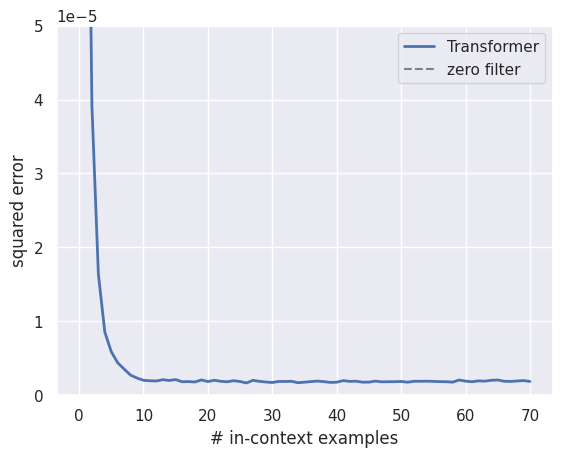

In [13]:
metric = task.get_metric()
# Compute per-point MSE
preds_np = pred.cpu().numpy()
ys_np = ys.cpu().numpy()
loss = ((preds_np - ys_np) ** 2).mean(axis=(0, 2))  # mean over batch and features, keep n_points

# Baseline for signal_conv: zero filter (output = 0)
baseline = 1.0

plt.plot(loss, lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero filter")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.ylim(0, .00005)
plt.legend()
plt.show()

# Visualize example signals

Let's plot some example input signals, their true outputs, and the model's predictions to see how well it learns the FIR filter.

In [14]:
xs2 = xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    xs2_device = xs2.to(model.device if hasattr(model, 'device') else device)
    ys2_device = ys2.to(model.device if hasattr(model, 'device') else device)
    pred2 = model(xs2_device, ys2_device).cpu()

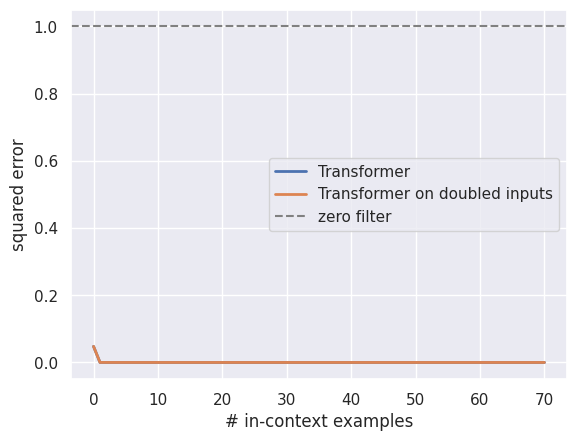

In [15]:
preds2_np = pred2.cpu().numpy()
ys2_np = ys2.cpu().numpy()
loss2 = ((preds2_np - ys2_np) ** 2).mean(axis=(0, 2))

plt.plot(loss, lw=2, label="Transformer")
plt.plot(loss2, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero filter")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [7]:
def plot_signal_examples(xs, ys, pred, conf, example_idx=0, n_points_to_show=10):
    """
    Stem-plot visualization of:
        - Input signal x
        - True output y
        - Predicted output ŷ

    Args:
        xs:   tensor (B, T, p or 2p)
        ys:   tensor (B, T, p or 2p)
        pred: tensor (B, T, p or 2p)
        conf: full training config (for domain strings)
        example_idx: which batch element to plot
        n_points_to_show: number of (x,y) examples to visualize
    """

    fig, axes = plt.subplots(n_points_to_show, 3, figsize=(15, 3*n_points_to_show))
    if n_points_to_show == 1:
        axes = axes.reshape(1, -1)

    domain_x = ('Time' if conf["training"]["data_kwargs"]["domain"] == "time"
                else "Time")
    domain_y = ('Time' if conf["training"]["task_kwargs"]["domain"] == "time"
                else "Time")

    for point_idx in range(n_points_to_show):

        x_signal = xs[example_idx, point_idx].cpu().numpy()
        y_true   = ys[example_idx, point_idx].cpu().numpy()
        y_pred   = pred[example_idx, point_idx].cpu().numpy()

        # --- Input signal ---
        axes[point_idx, 0].stem(
            x_signal, linefmt='b-', markerfmt='bo', basefmt='k-'
        )
        axes[point_idx, 0].set_title(f'Input Signal (point {point_idx+1})')
        axes[point_idx, 0].set_xlabel(domain_x)
        axes[point_idx, 0].grid(True, alpha=0.3)

        # --- True output ---
        axes[point_idx, 1].stem(
            y_true, linefmt='g-', markerfmt='go', basefmt='k-'
        )
        axes[point_idx, 1].set_title(f'True Output (point {point_idx+1})')
        axes[point_idx, 1].set_xlabel(domain_y)
        axes[point_idx, 1].grid(True, alpha=0.3)

        # --- Prediction vs true ---
        axes[point_idx, 2].stem(
            y_true, linefmt='g-', markerfmt='go', basefmt='k-', label='True'
        )
        axes[point_idx, 2].stem(
            y_pred, linefmt='r--', markerfmt='ro', basefmt='k-', label='Pred'
        )
        axes[point_idx, 2].set_title(f'Prediction vs True (point {point_idx+1})')
        axes[point_idx, 2].set_xlabel(domain_y)
        axes[point_idx, 2].legend()
        axes[point_idx, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Final-point error
    final_error = ((y_pred - y_true) ** 2).mean()
    print(f"MSE for final point: {final_error:.6f}")

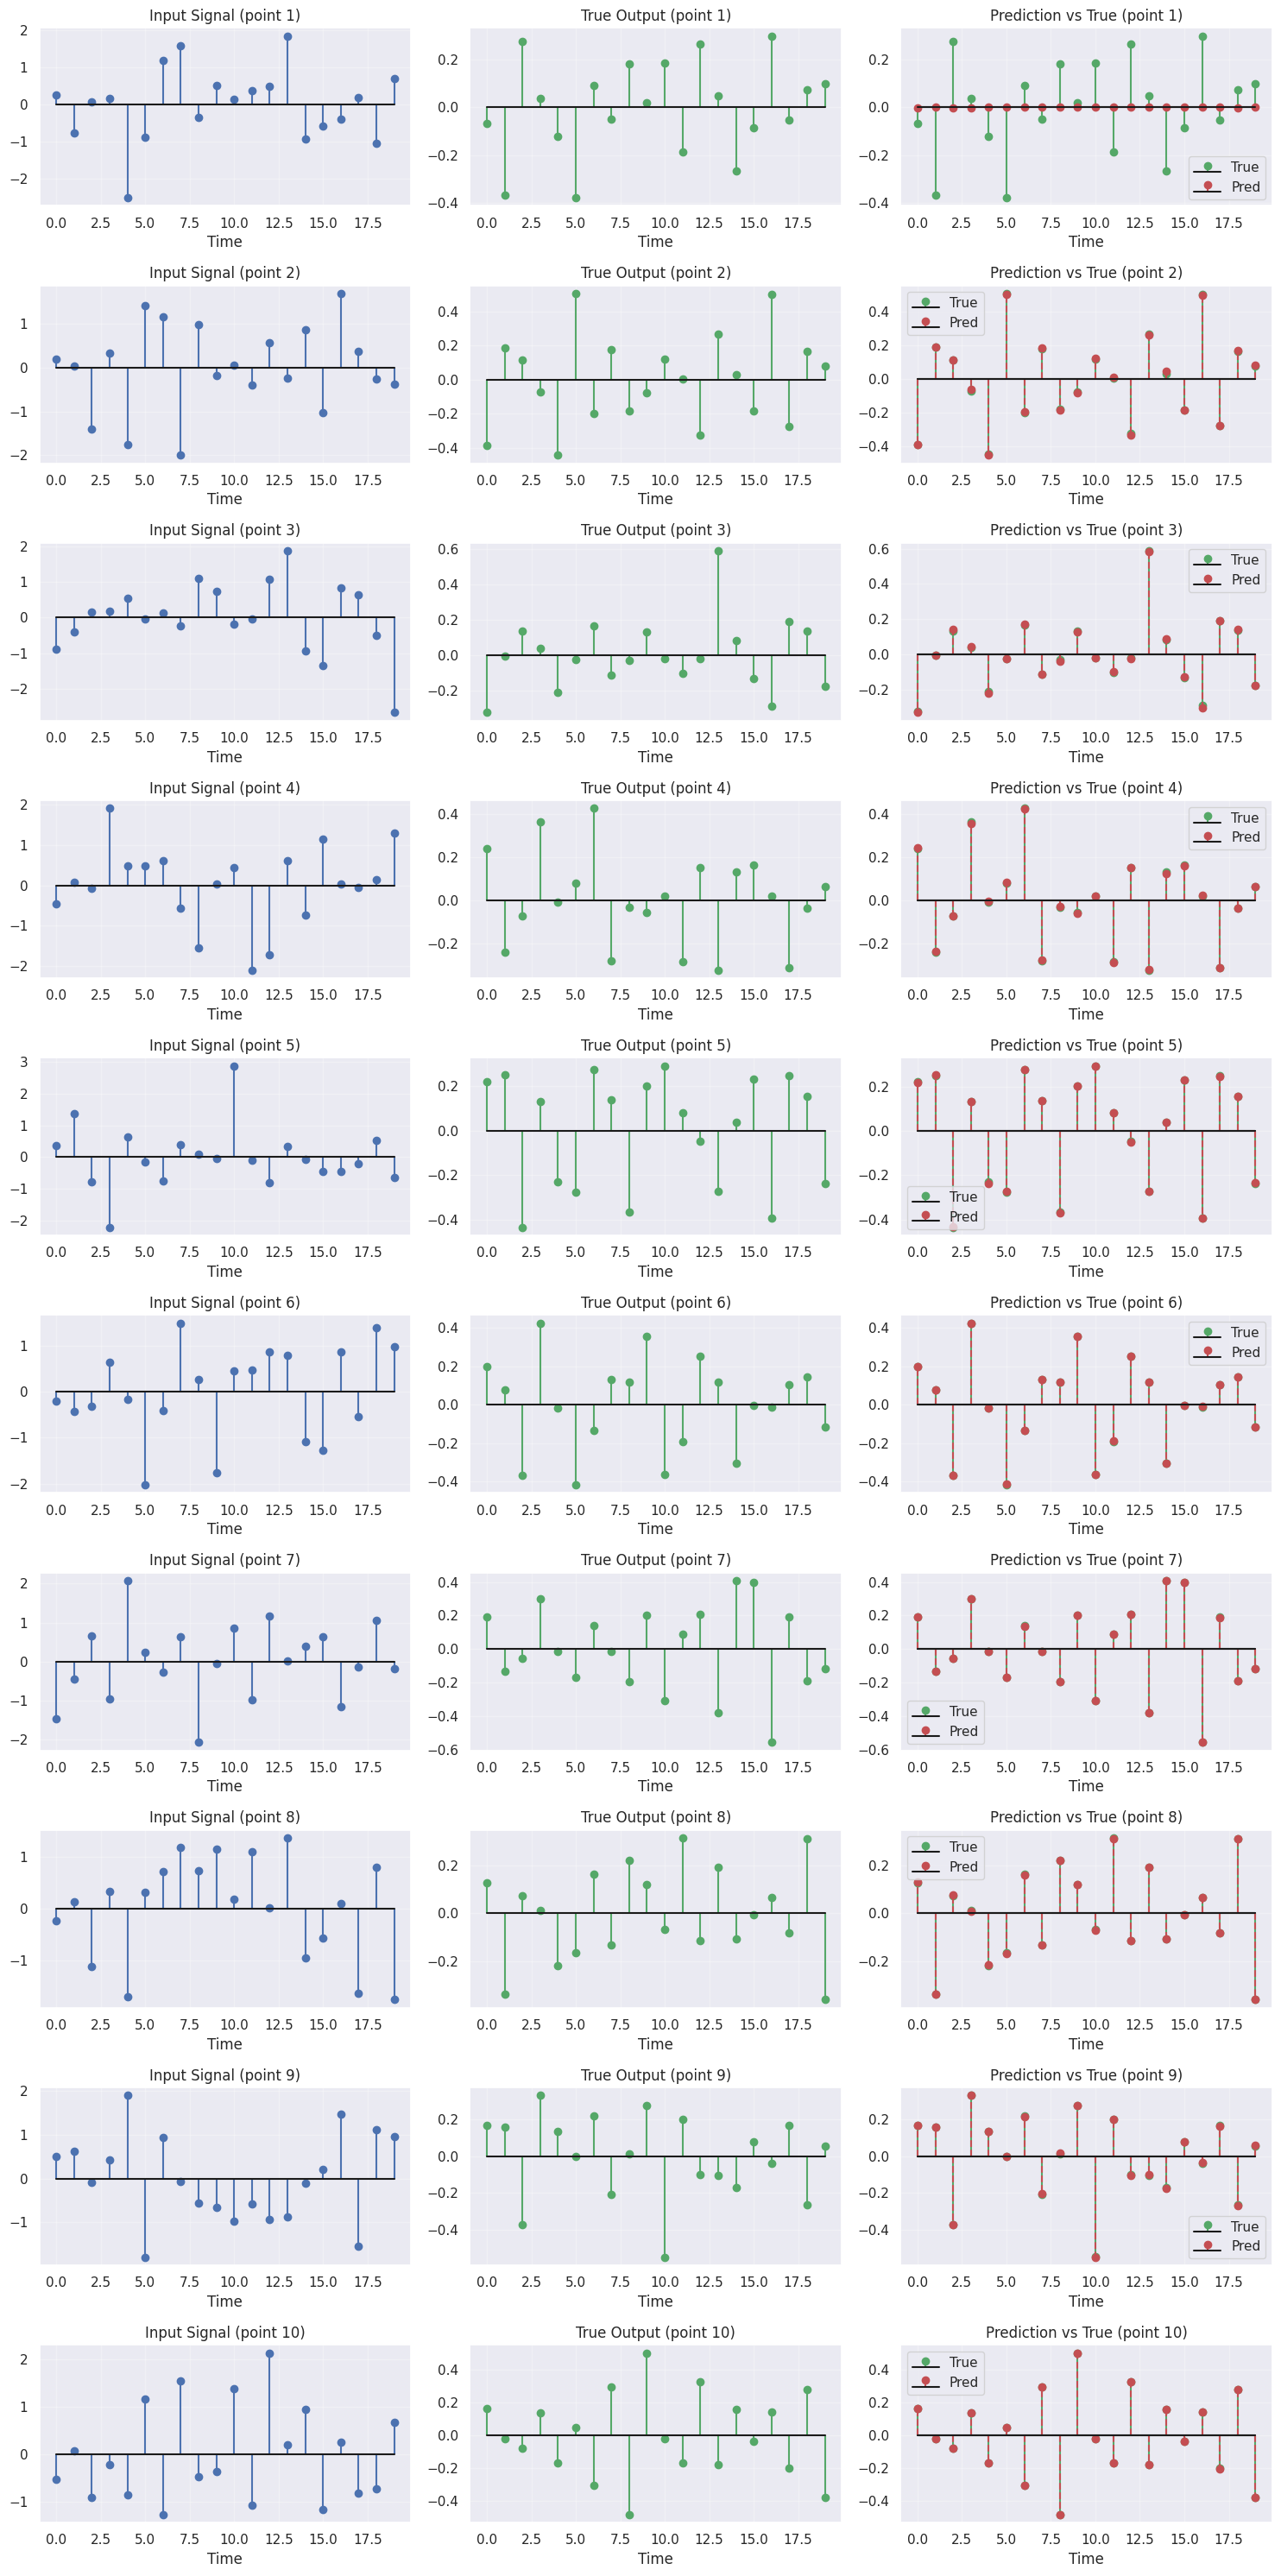

MSE for final point: 0.000001


In [17]:
plot_signal_examples(xs, ys, pred, conf_time, example_idx=0, n_points_to_show=10)


# Frequency Analysis

In [62]:
run_path_freq = "output/freq_p20_fir20_loss_space_time_no_norm_rfft_ortho"

# Load configs to verify
_, conf_freq = get_model_from_run(run_path_freq, only_conf=True)

print("Freq domain model:", conf_freq.training.data_kwargs.domain, "n_dims:", conf_freq.model.n_dims)

Freq domain model: freq n_dims: 22


In [63]:
# Choose which model to evaluate

# Compute metrics (this will save to metrics.json in the run directory)
recompute_metrics = True
if recompute_metrics:
    metrics = get_run_metrics(run_path_freq)

/home/leonkornfeld/182-Final-Project/src/eval.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(state_path, map_location="cpu")
100%|██████████| 1/1 [0

In [64]:
model_freq, conf_freq = get_model_from_run(run_path_freq)

# Move model to appropriate device
if torch.cuda.is_available():
    model_freq = model_freq.cuda()
elif torch.backends.mps.is_available():
    model_freq = model_freq.to("mps")
model_freq.eval()

n_dims = conf_freq.model.n_dims
batch_size = 1000

# Override device for samplers
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

data_kwargs = dict(conf_freq.training.data_kwargs)
task_kwargs = dict(conf_freq.training.task_kwargs)
data_kwargs['device'] = device
task_kwargs['device'] = device

data_sampler = get_data_sampler(conf_freq.training.data, n_dims, **data_kwargs)
task_sampler = get_task_sampler(
    conf_freq.training.task,
    n_dims,
    batch_size,
    **task_kwargs
)

In [65]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf_freq.training.curriculum.points.end)
ys = task.evaluate(xs)

In [66]:
print(xs.shape)
print(ys.shape)

torch.Size([1000, 41, 22])
torch.Size([1000, 41, 22])


In [5]:
def _interleaved_to_complex(vec_2p: torch.Tensor) -> torch.Tensor:
    re = vec_2p[..., 0::2]
    im = vec_2p[..., 1::2]
    return torch.complex(re, im)


def interleaved_freq_to_time(xs_freq: torch.Tensor, p: int) -> torch.Tensor:
    """
    xs_freq: (B, T, 2p) real, interleaved [Re0, Im0, Re1, Im1, ...] along the last dim
    p: signal length in time domain
    fft_norm: must match the norm used in forward FFT ('ortho' in your case)

    Returns:
        xs_time: (B, T, p) real time-domain signals
    """
    # 1. Convert interleaved real/imag back to complex
    Z = _interleaved_to_complex(xs_freq)   # shape: (B, T, p), complex

    # 2. IFFT along the last dimension
    xs_time = torch.fft.irfft(Z,  dim=-1, norm = "ortho").real
    return xs_time

In [68]:
with torch.no_grad():
    xs_device = xs.to(model_freq.device if hasattr(model_freq, 'device') else device)
    ys_device = ys.to(model_freq.device if hasattr(model_freq, 'device') else device)
    pred_freq = model_freq(xs_device, ys_device).cpu()

In [69]:
p = (xs.shape[-1] -1) * 2

print(xs.shape[-1] -1 * 2)
xs_freq_to_time = interleaved_freq_to_time(xs, p)
print(xs_freq_to_time.shape)
ys_freq_to_time = interleaved_freq_to_time(ys, p)
pred_freq_to_time = interleaved_freq_to_time(pred_freq, p)

20
torch.Size([1000, 41, 20])


In [70]:
print(xs.shape)

torch.Size([1000, 41, 22])


[0.00254688 0.0030388  0.00274303 0.00232783 0.00220301 0.00206993
 0.00202785 0.00204702 0.00193566 0.00189384 0.00192024 0.00191198
 0.00198503 0.00191046 0.00194599 0.00193446 0.00194437 0.001937
 0.00192703 0.00195233 0.00194332 0.00191807 0.00193698 0.00192533
 0.00194297 0.00195813 0.00195562 0.00196092 0.00195793 0.0019484
 0.00195912 0.00196735 0.00189427 0.00194702 0.00195758 0.00193147
 0.00196761 0.0019291  0.00196352 0.00196334 0.00195873]


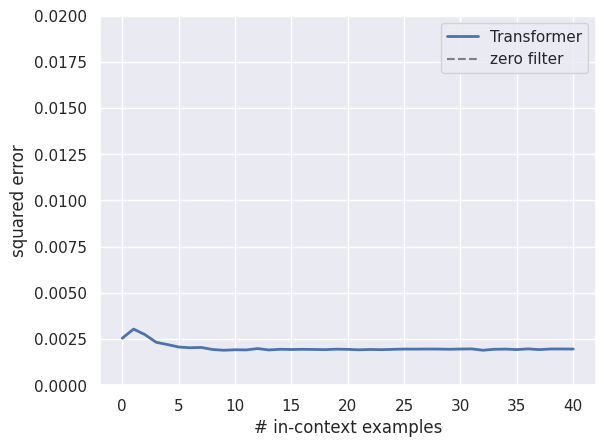

In [71]:
#Frequency Domain
metric = task.get_metric()
# Compute per-point MSE
preds_np = pred_freq_to_time.cpu().numpy()
ys_np = ys_freq_to_time.cpu().numpy()
loss = ((preds_np - ys_np) ** 2).mean(axis=(0, 2))  # mean over batch and features, keep n_points
print(loss)
# Baseline for signal_conv: zero filter (output = 0)
baseline = 1.0

plt.plot(loss, lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero filter")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.ylim(0, .02)
plt.legend()
plt.show()

In [72]:
with torch.no_grad():
    xs_time_device = xs_freq_to_time.to(model_time.device if hasattr(model_time, 'device') else device)
    ys_time_device = ys_freq_to_time.to(model_time.device if hasattr(model_time, 'device') else device)
    pred_time = model_time(xs_time_device, ys_time_device).cpu()

[2.5554611e-03 7.9450075e-04 2.2549825e-04 1.0988718e-04 6.7505309e-05
 5.1031930e-05 4.2287993e-05 3.7060039e-05 3.5924561e-05 3.2441221e-05
 3.2177632e-05 3.1395200e-05 3.0699375e-05 3.0776166e-05 3.2258005e-05
 3.0319639e-05 3.1102601e-05 3.2305314e-05 3.1500145e-05 3.1397562e-05
 3.0932035e-05 3.1691601e-05 3.1442047e-05 3.1546511e-05 3.1614356e-05
 3.1958803e-05 3.1892003e-05 3.2052369e-05 3.2291453e-05 3.3705724e-05
 3.2960412e-05 3.3853434e-05 3.4140710e-05 3.3556902e-05 3.6085774e-05
 3.3370135e-05 3.3843786e-05 3.3910452e-05 3.4568104e-05 3.6248406e-05
 3.3988592e-05]


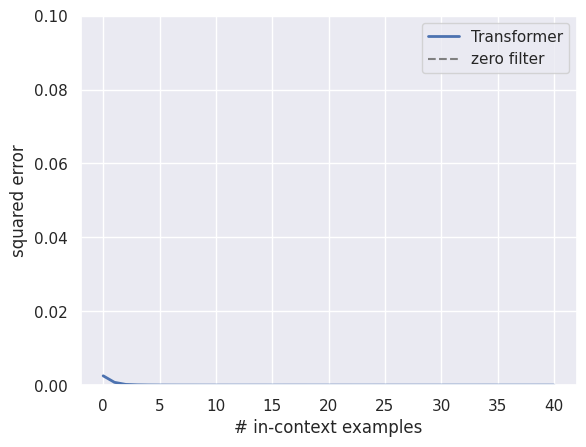

In [73]:
#Time domain

metric = task.get_metric()
# Compute per-point MSE
preds_np = pred_time.cpu().numpy()
ys_np = ys_time_device.cpu().numpy()
loss = ((preds_np - ys_np) ** 2).mean(axis=(0, 2))  # mean over batch and features, keep n_points
print(loss)
# Baseline for signal_conv: zero filter (output = 0)
baseline = 1.0

plt.plot(loss, lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero filter")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.ylim(0, .1)
plt.legend()
plt.show()

In [75]:
plot_signal_examples(xs_freq_to_time, ys_freq_to_time, pred_freq_to_time, conf_time, example_idx=0, n_points_to_show=40)


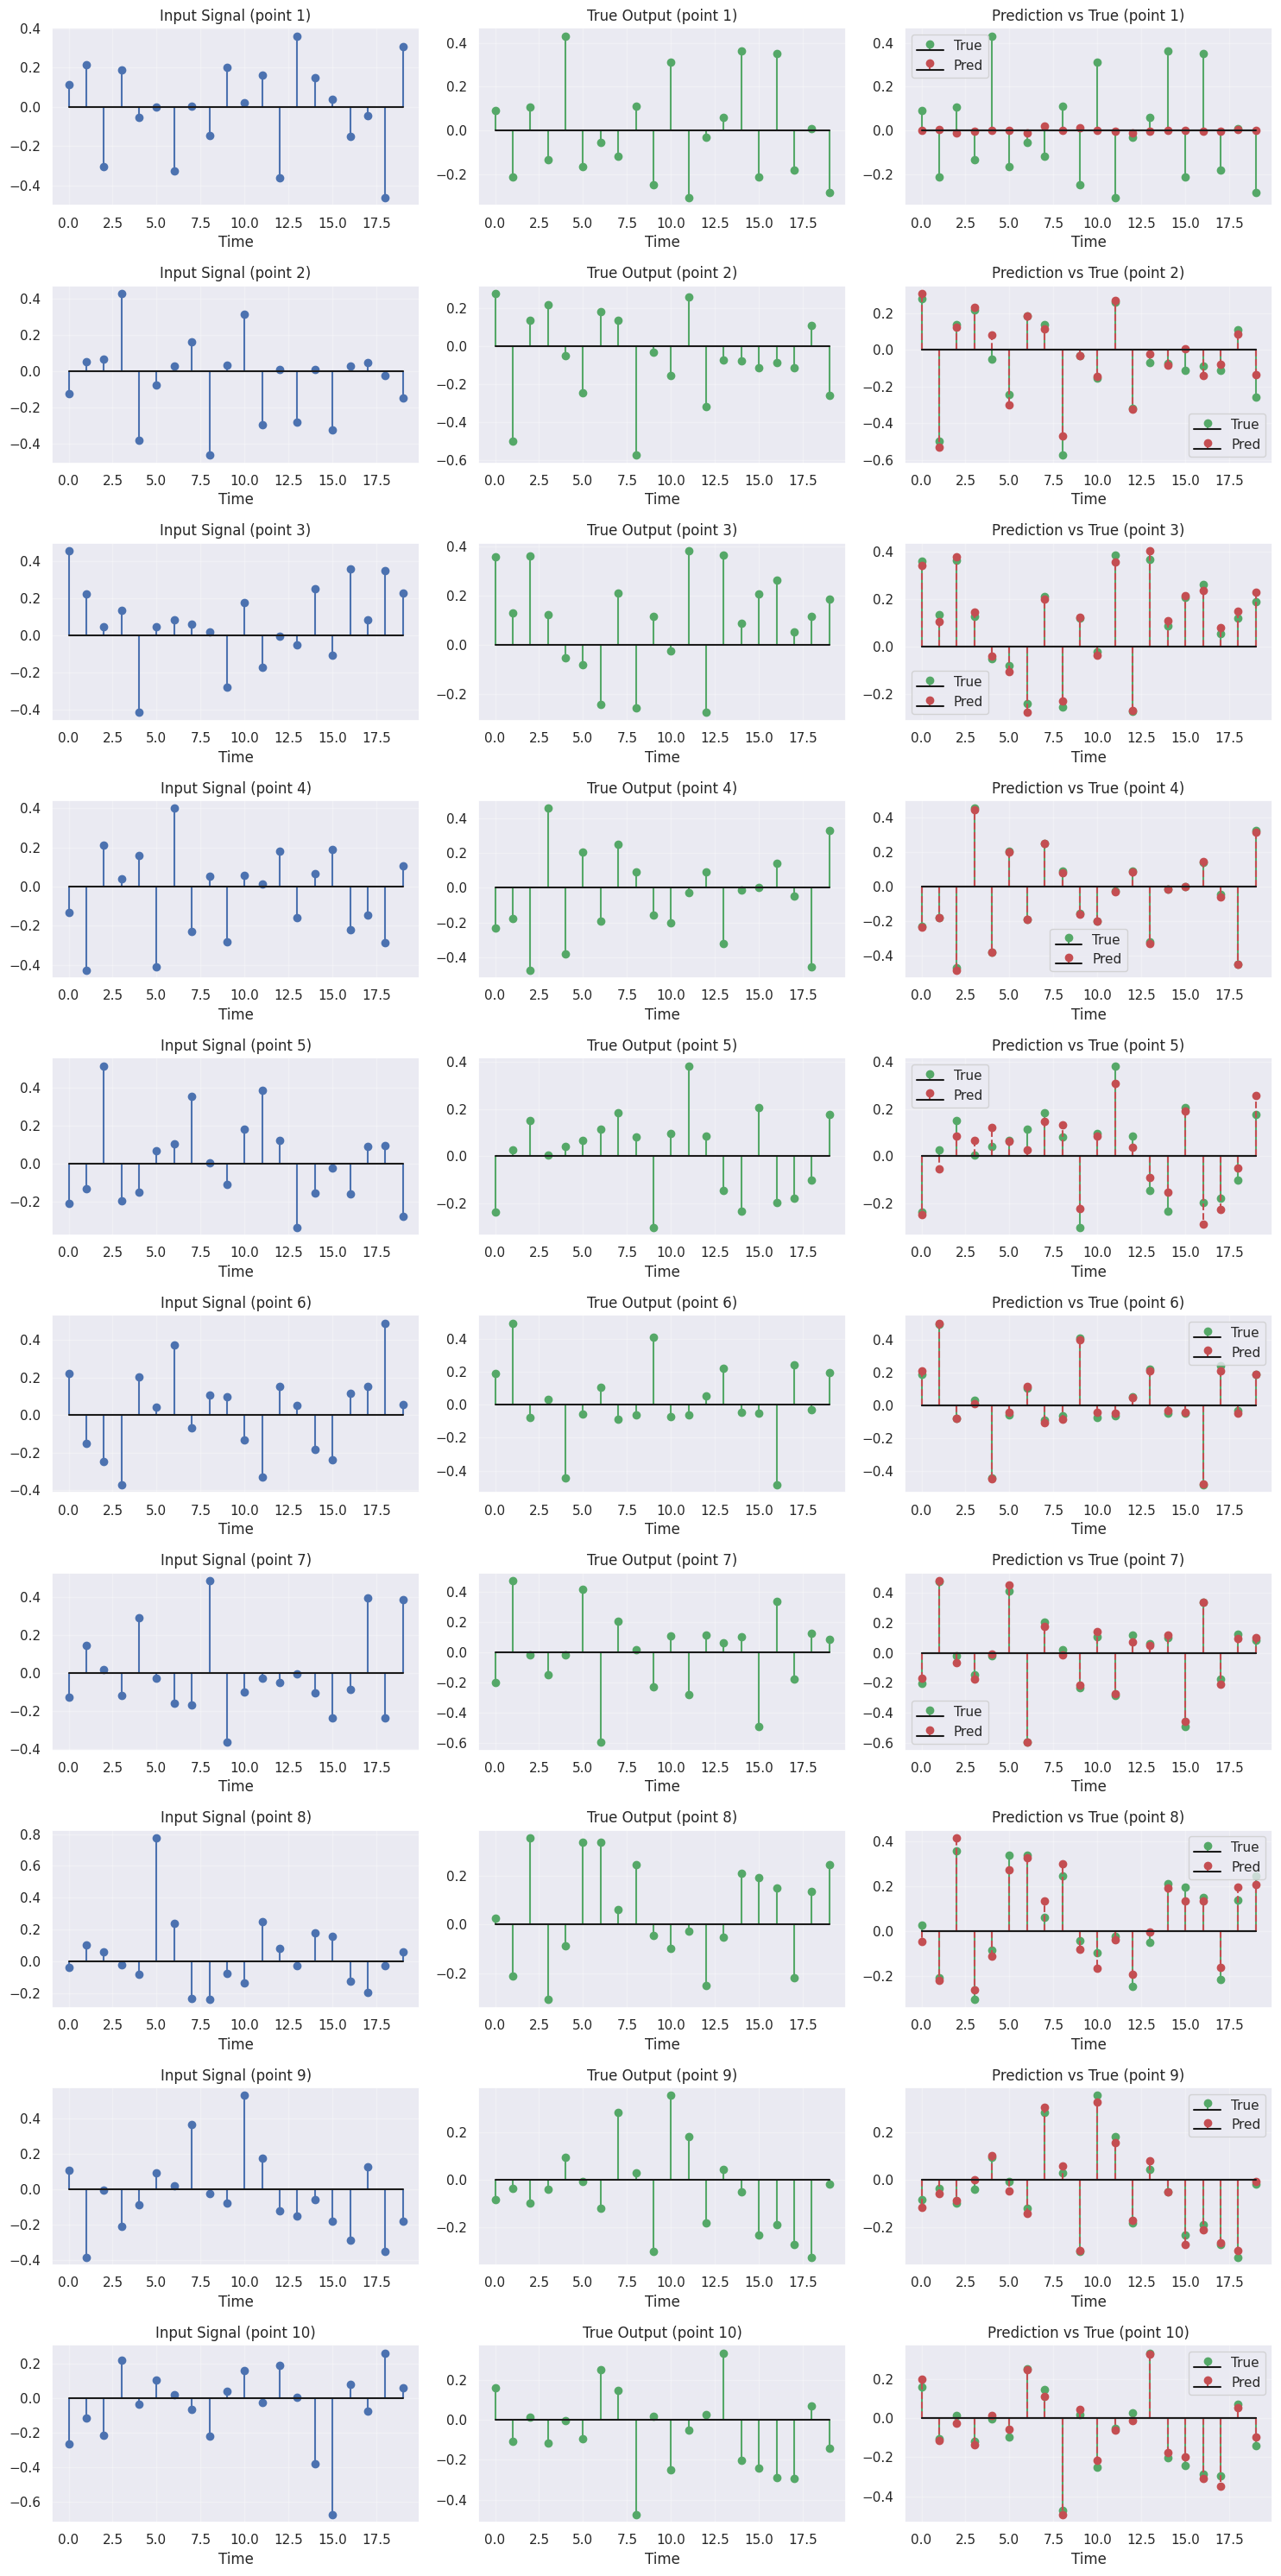

MSE for final point: 0.000978


In [96]:
plot_signal_examples(xs_freq_to_time, ys_freq_to_time, pred_time, conf_time, example_idx=0, n_points_to_show=10)


## Squared error vs in-context examples for multiple models

In this section we compare four models by plotting their **time-domain squared error** as a function of the number of in-context examples. For each model we compute the per-point MSE across the batch and then plot the **batch mean** with a **standard deviation band**.


Evaluating Frequency Period 20, FIR 5 from output/freq_p20_fir5_loss_space_time_b256_dec4_1331 ...
torch.Size([256, 55, 22])


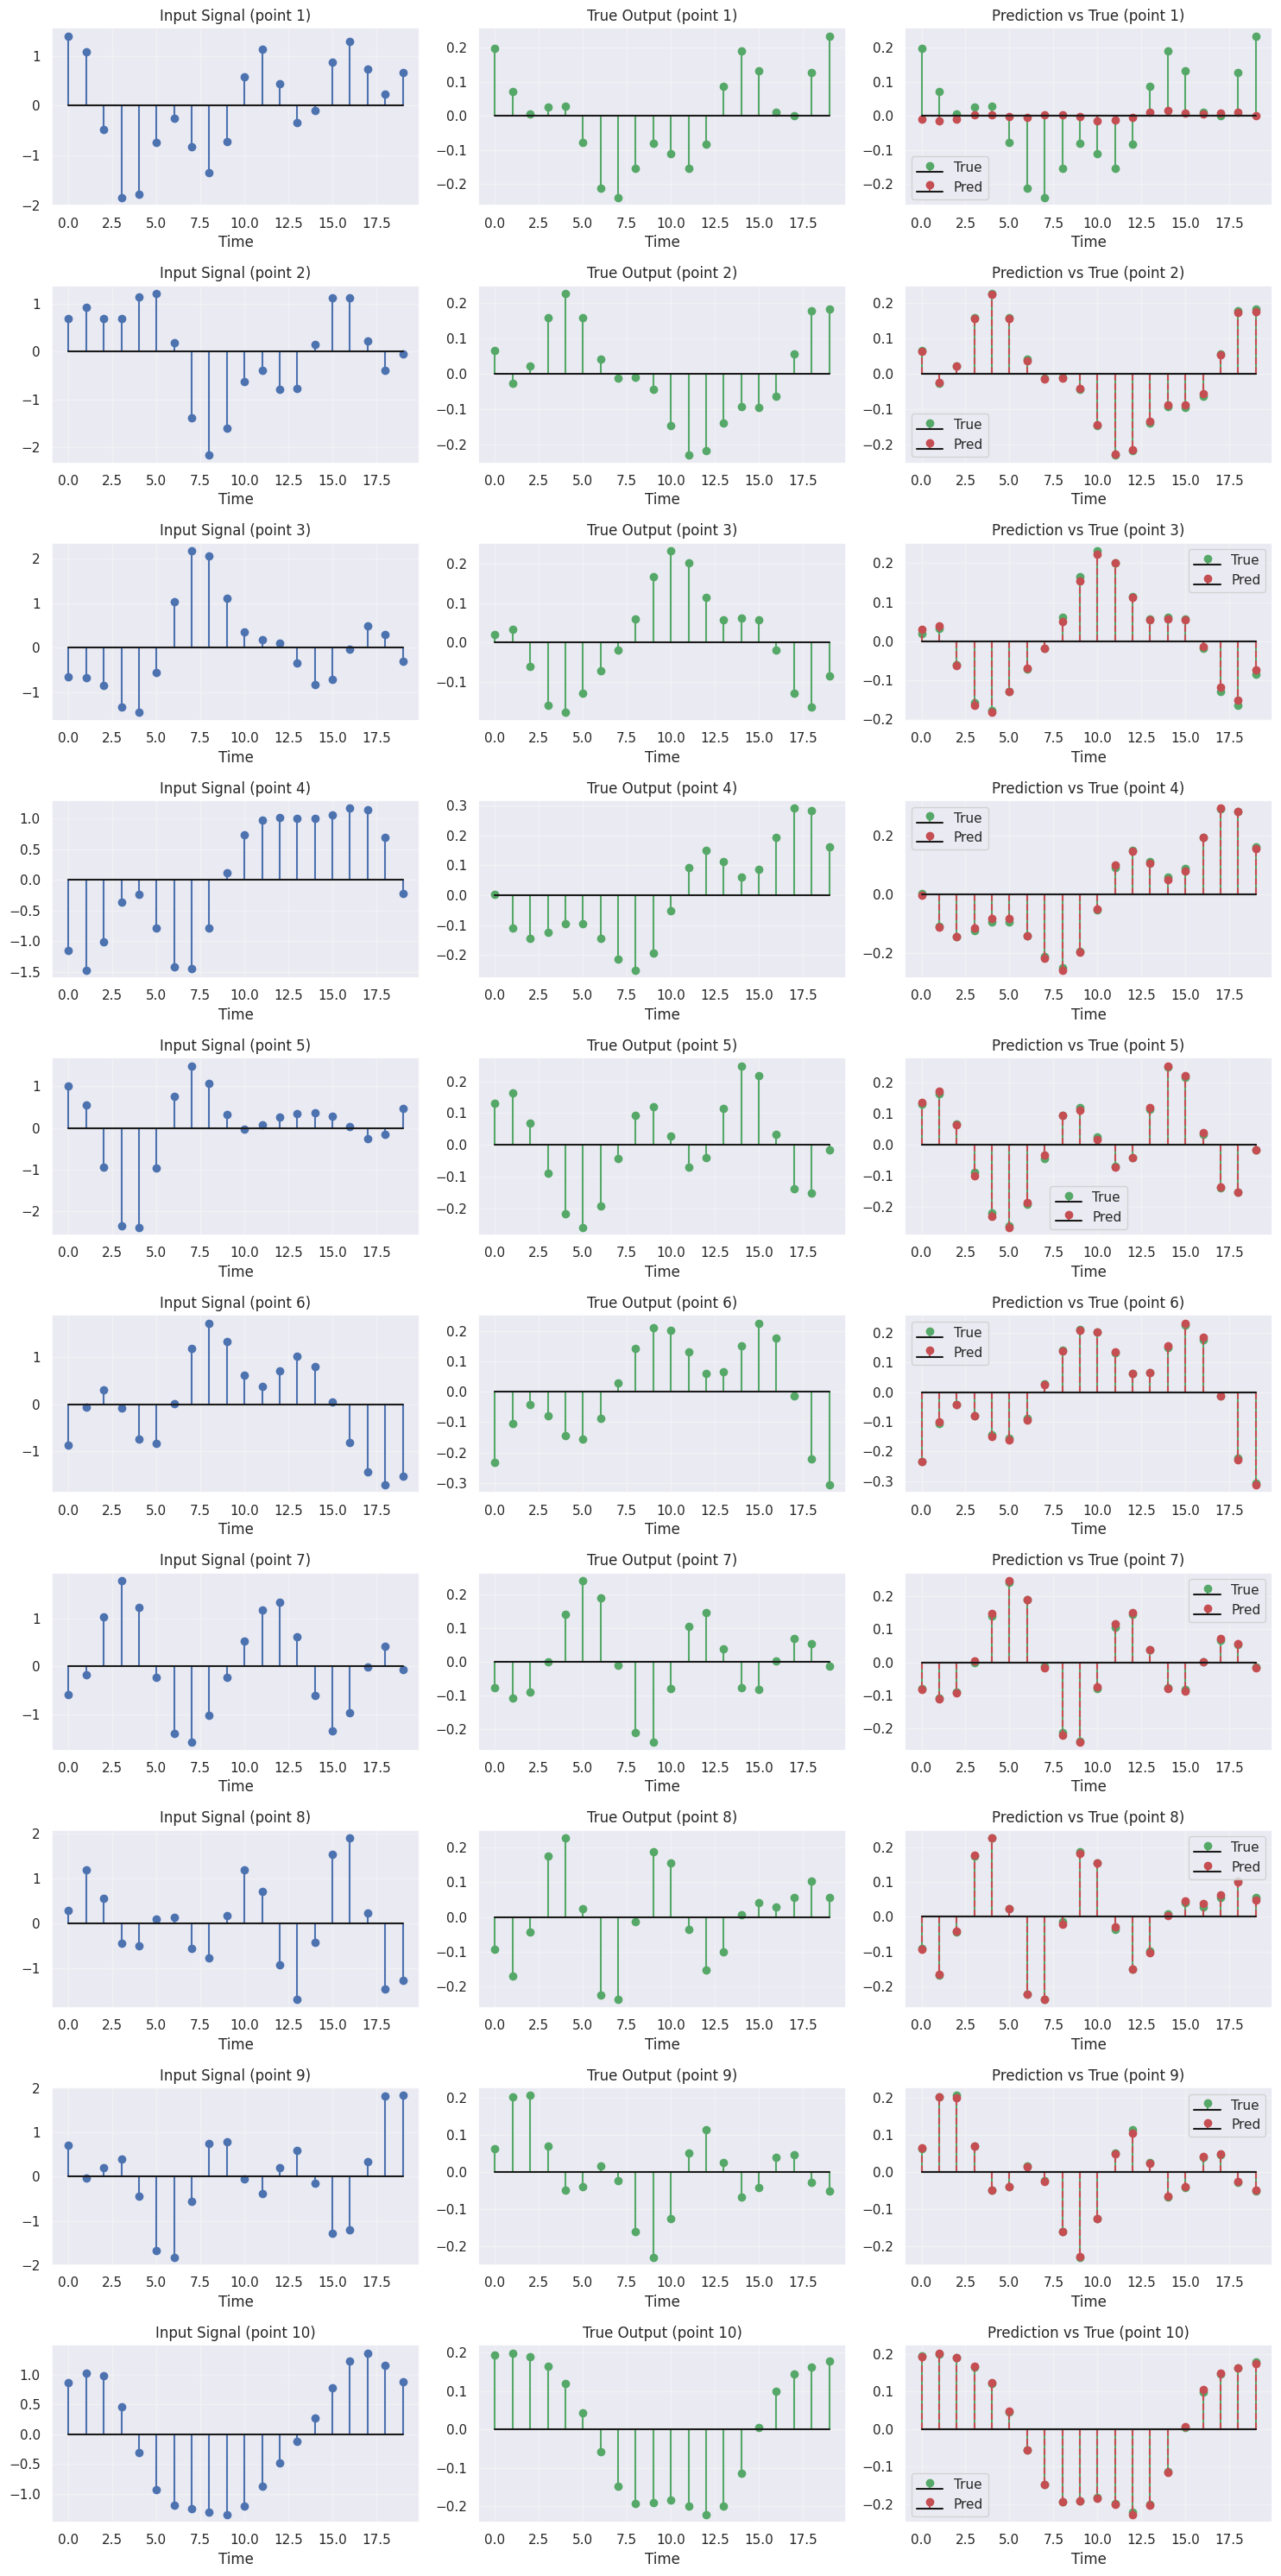

MSE for final point: 0.000007
Evaluating Frequency Period 20, FIR 20 from output/freq_p20_fir20_loss_space_time_b256_dec4_1443 ...
torch.Size([256, 55, 22])


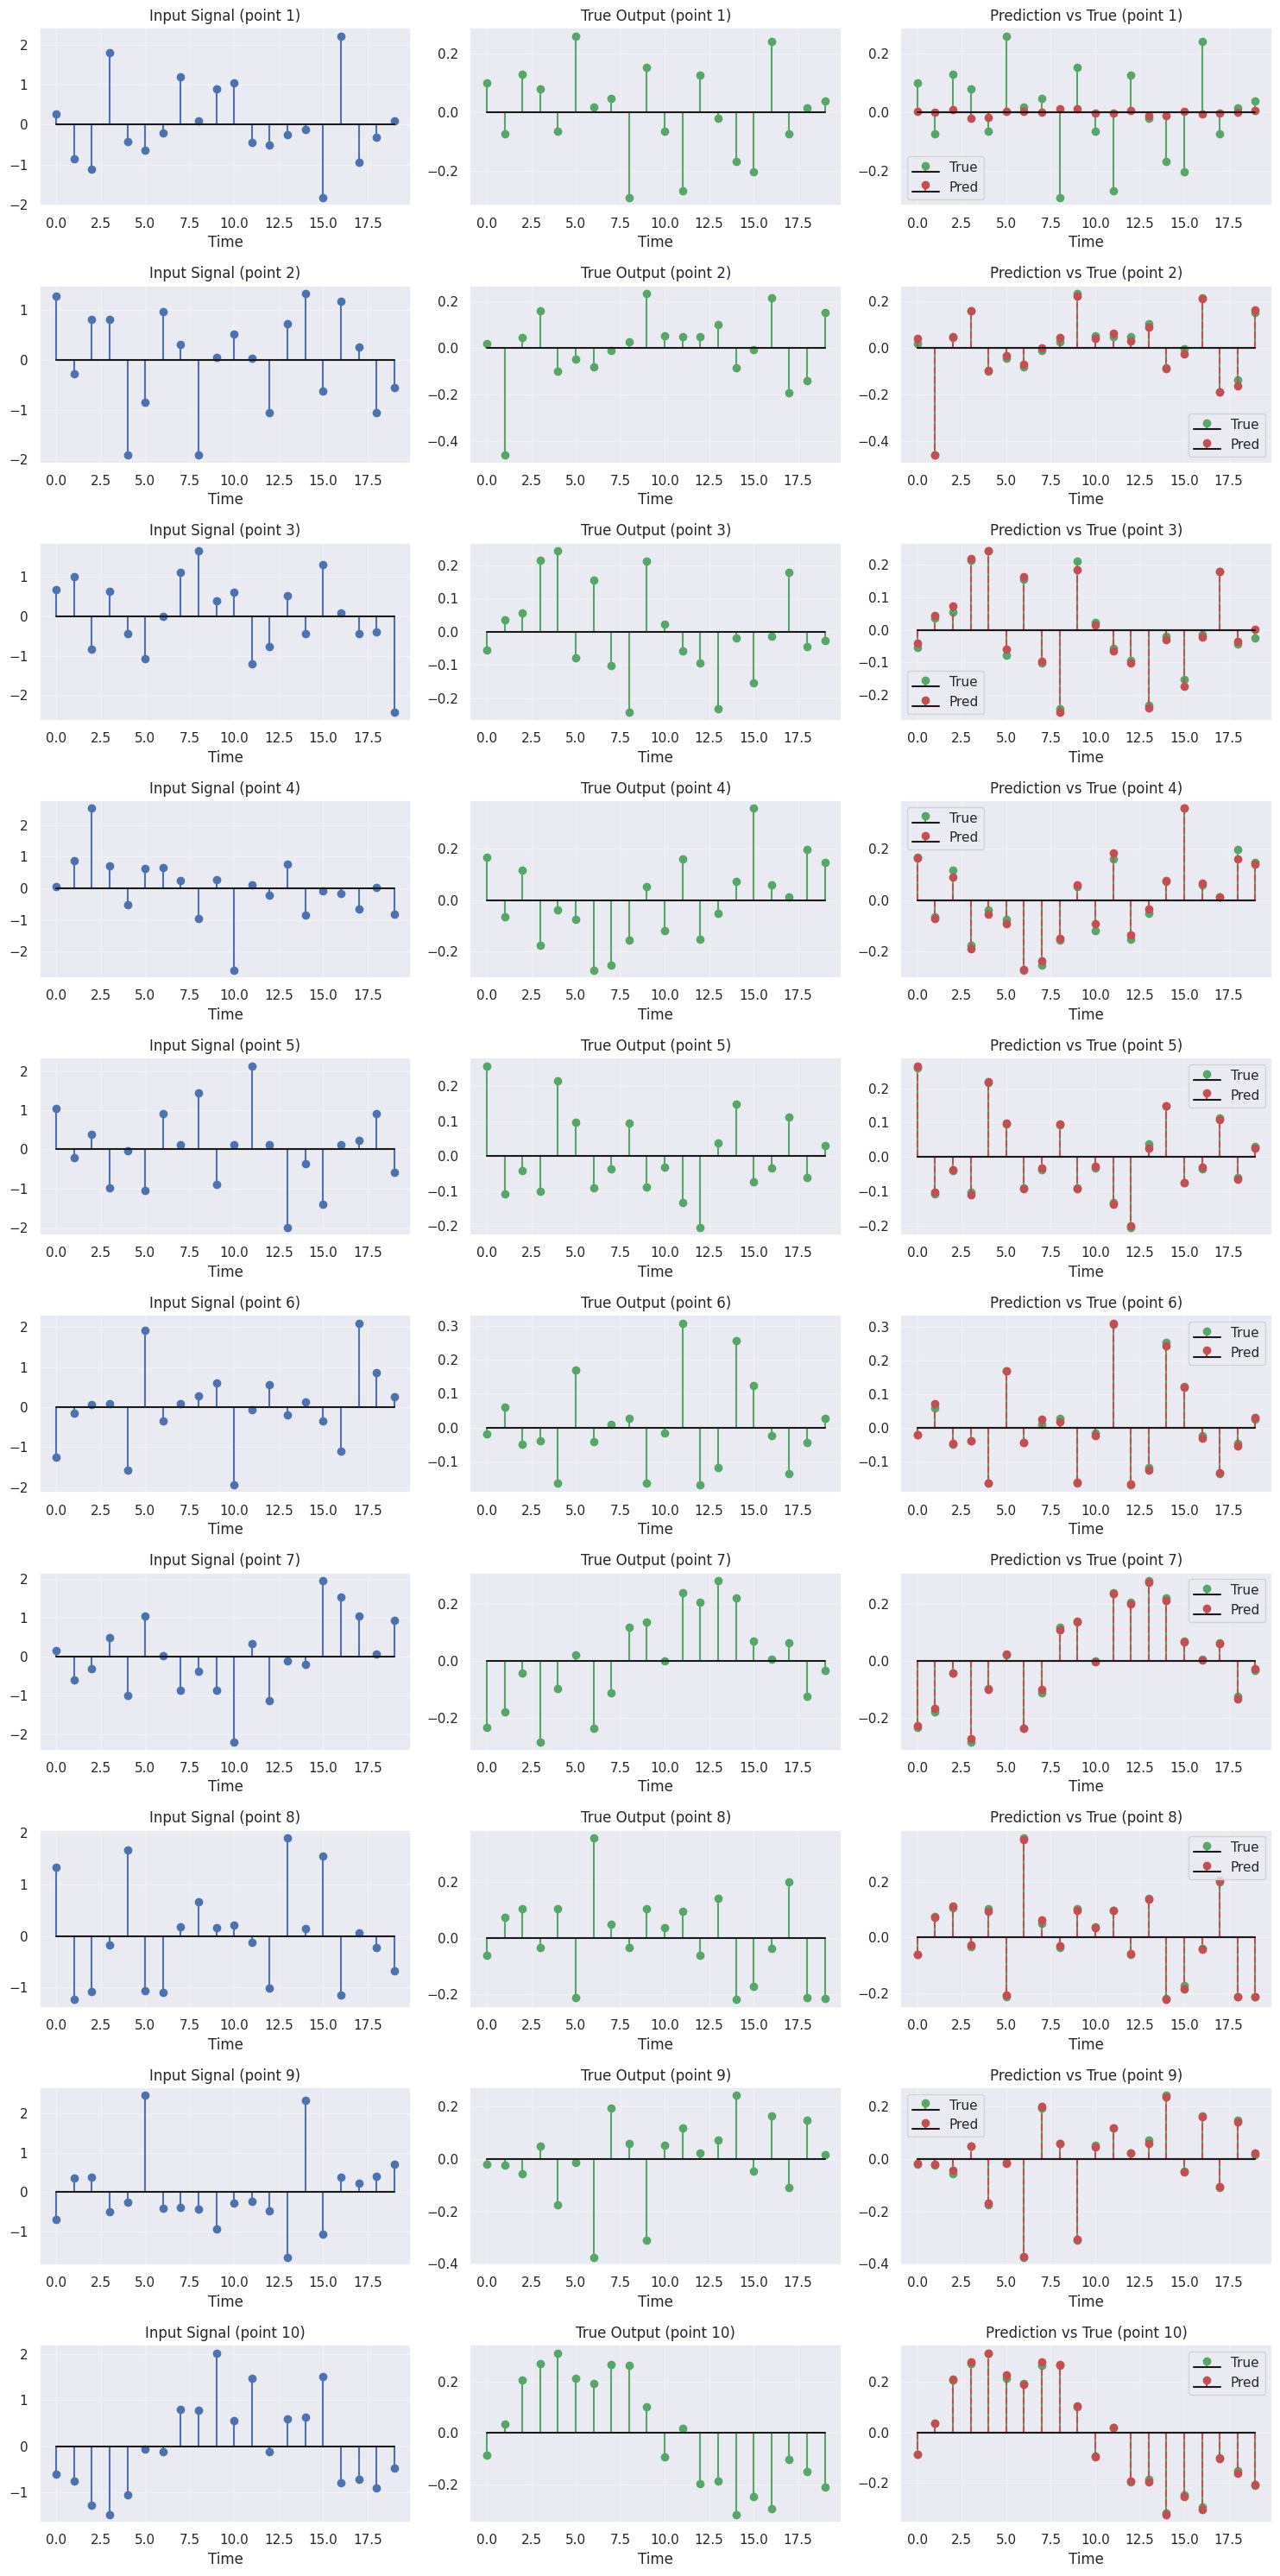

MSE for final point: 0.000053
Evaluating Time Period 20, FIR 5 from output/time_p20_fir5_context_batch256_dec4_1229 ...
torch.Size([256, 55, 20])


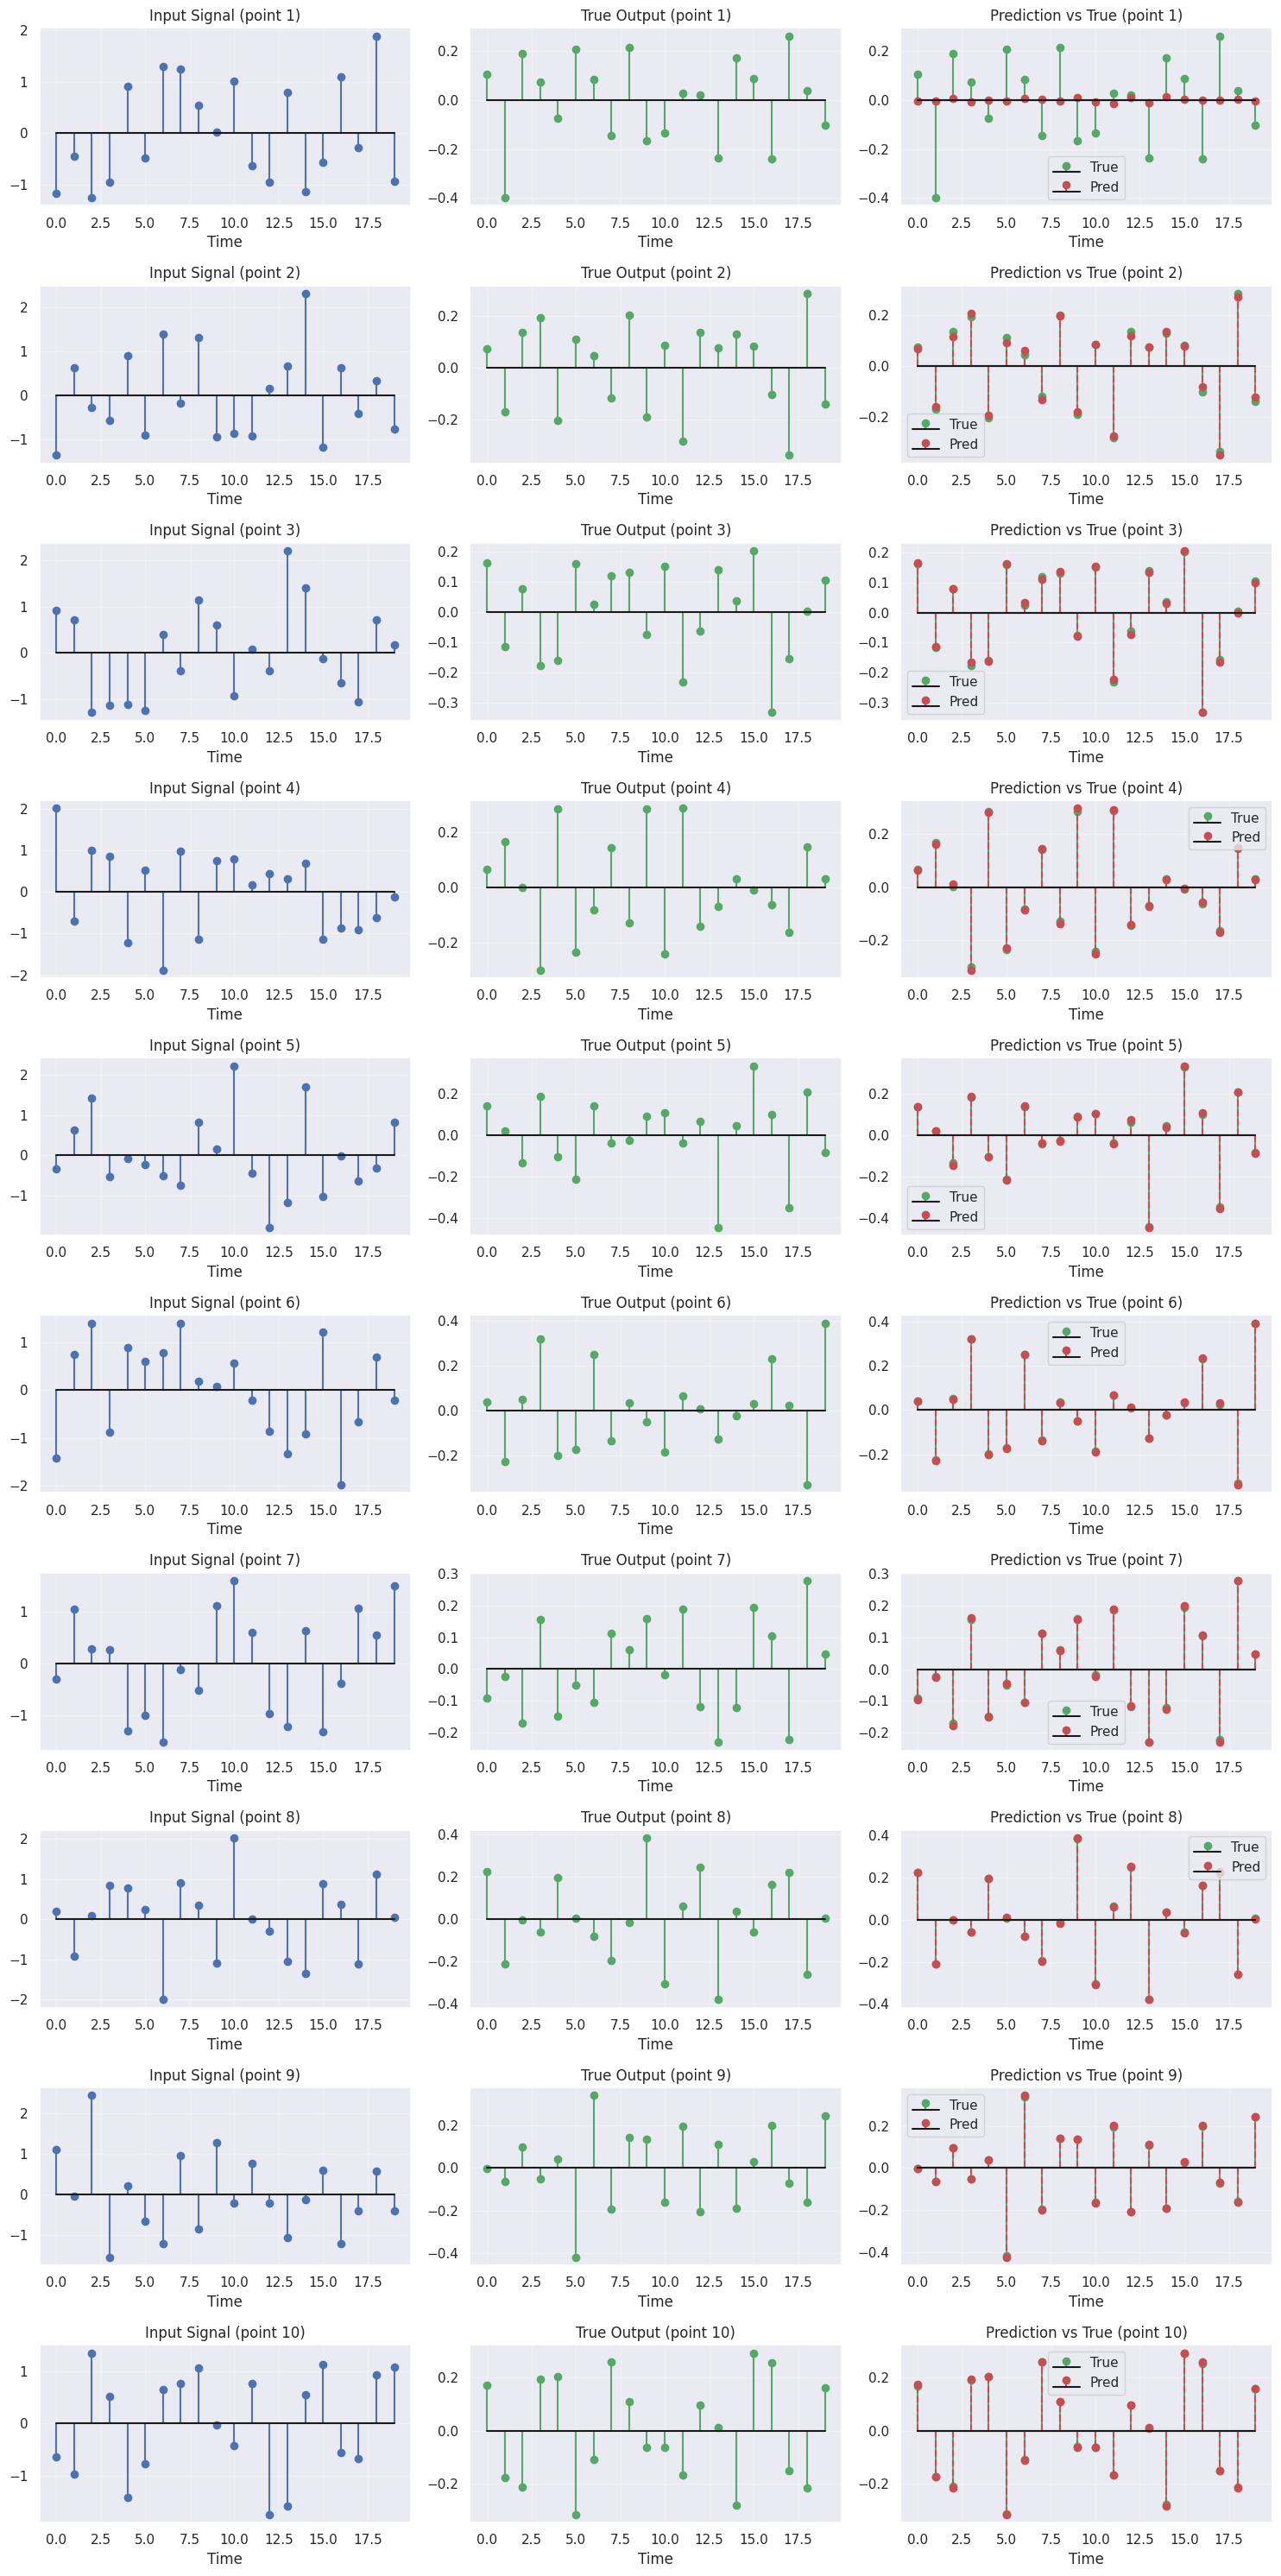

MSE for final point: 0.000008
Evaluating Time Period 20, FIR 20 from output/bigbatch_star ...
torch.Size([256, 71, 20])


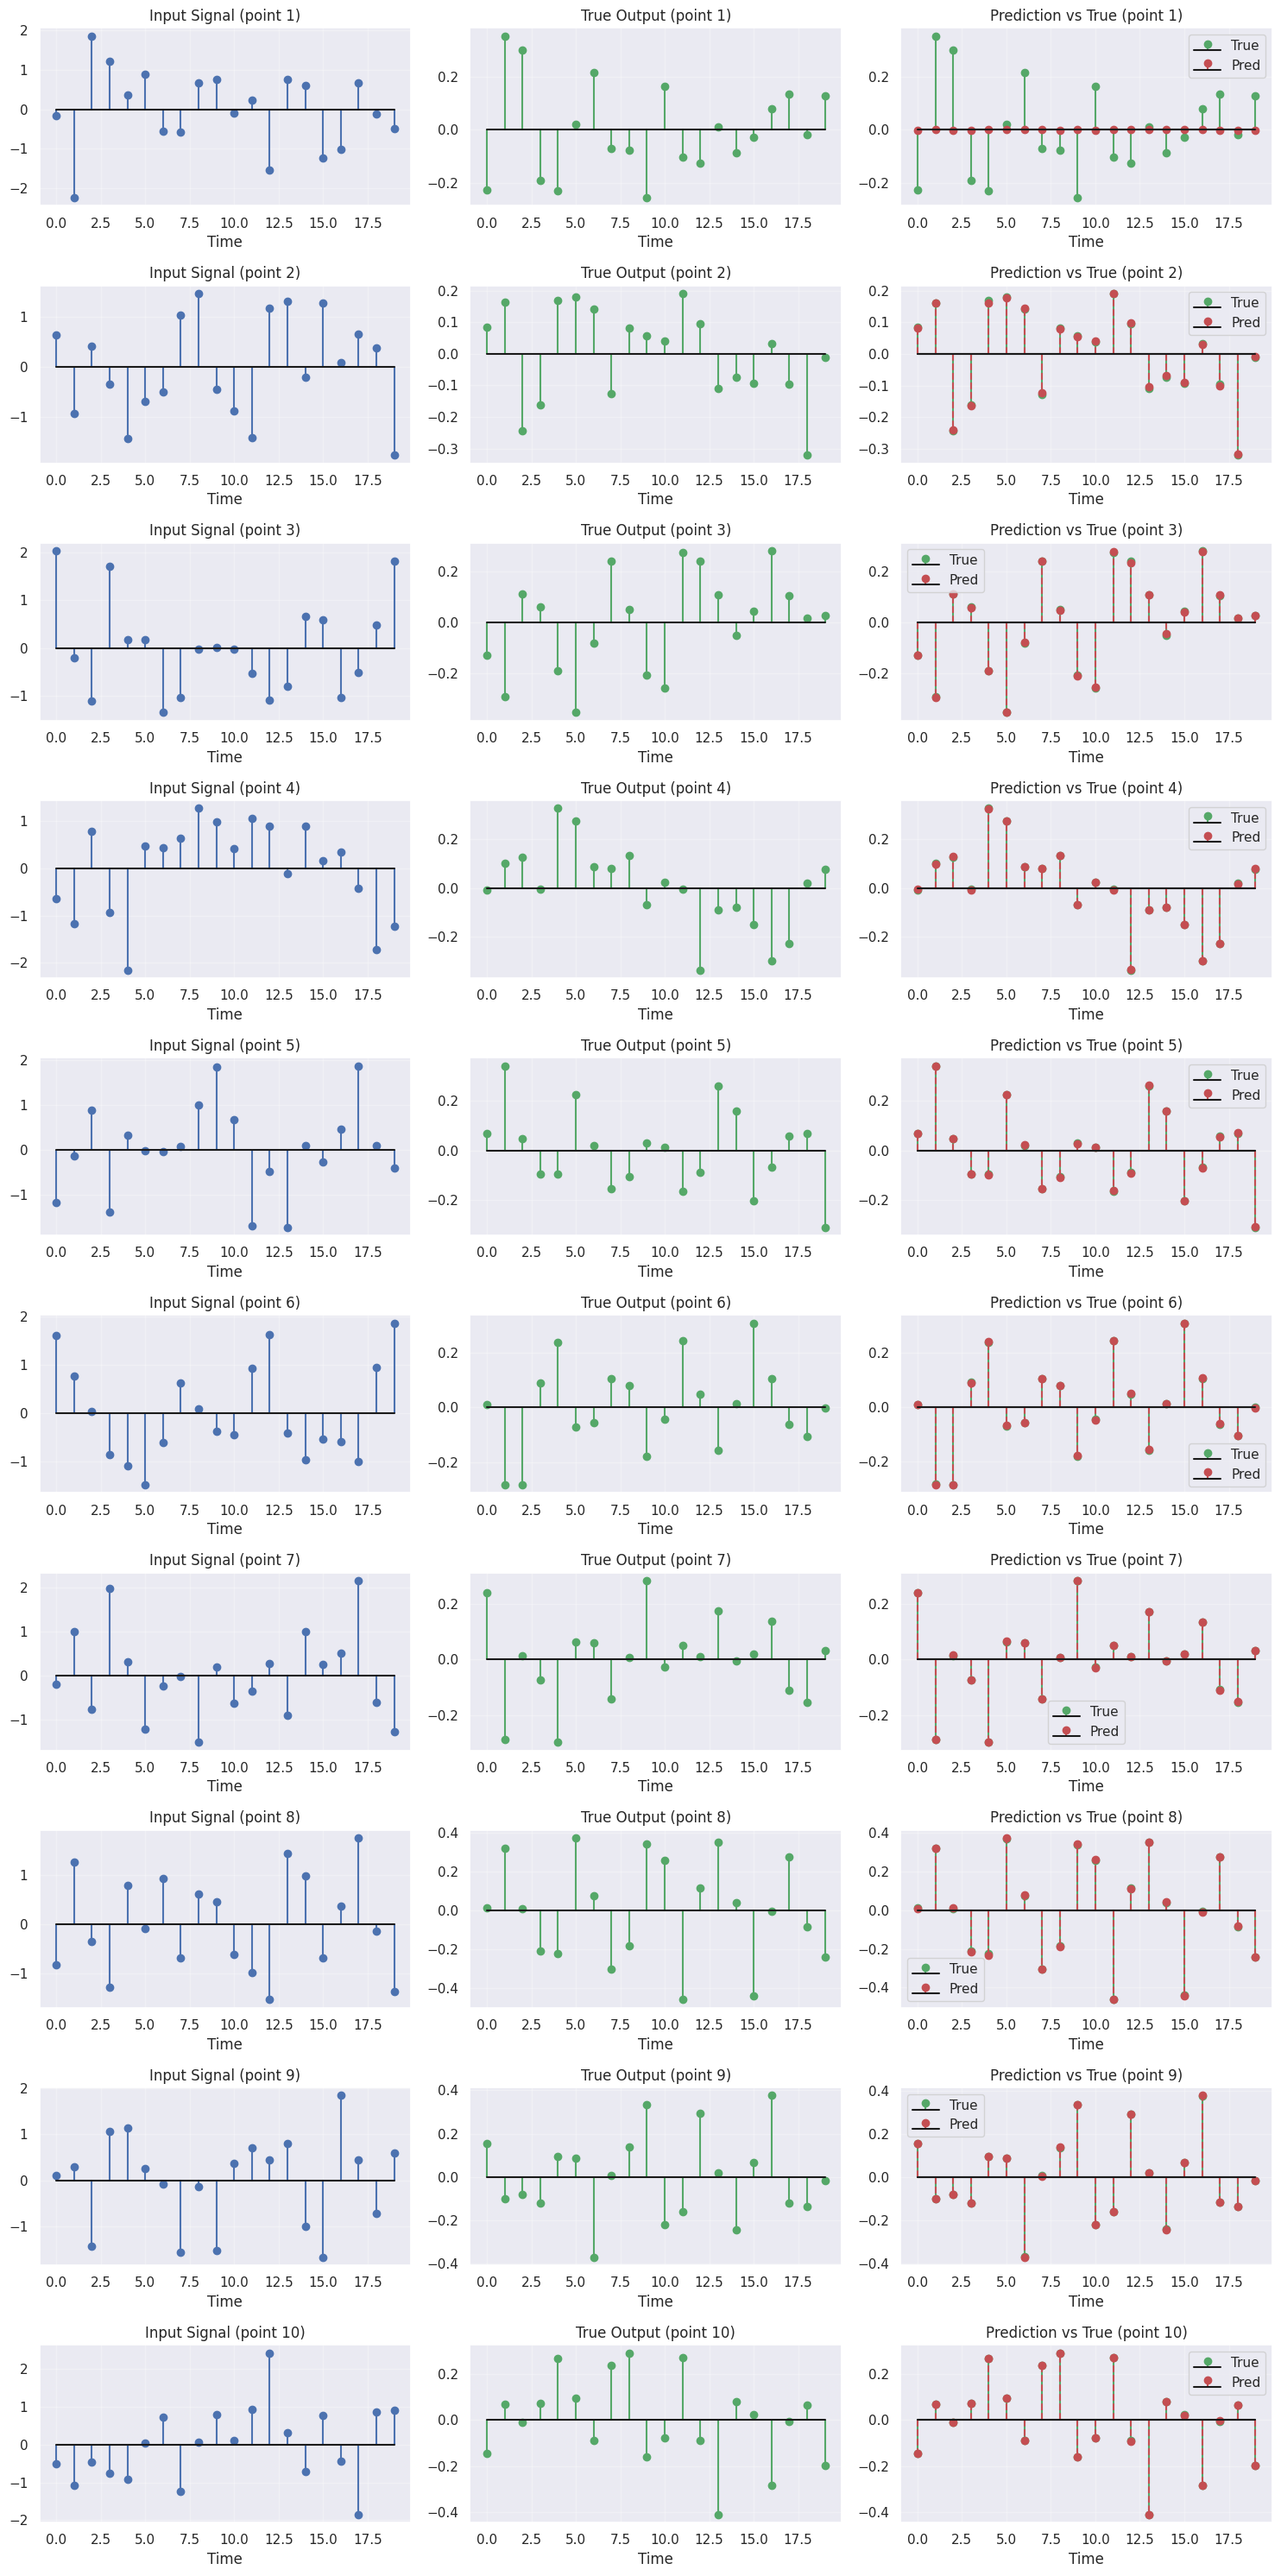

MSE for final point: 0.000001


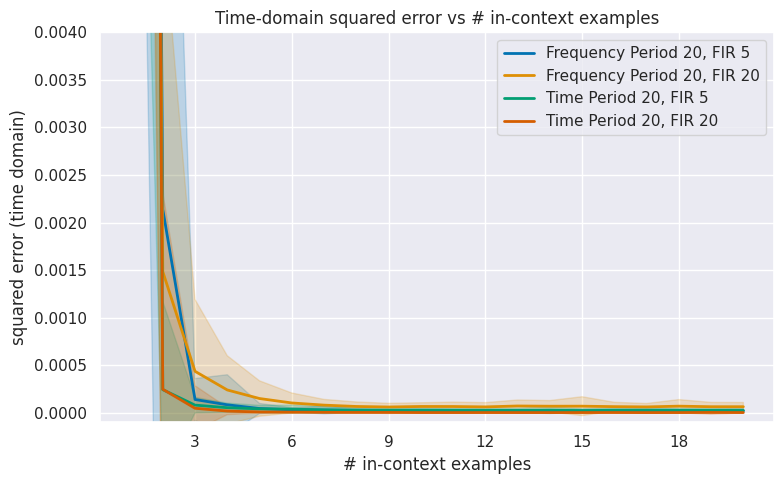

In [10]:
import numpy as np
from collections import OrderedDict

# Paths for the four models of interest (relative to project root)
model_specs = OrderedDict([
    ("Frequency Period 20, FIR 5", "output/freq_p20_fir5_loss_space_time_b256_dec4_1331"),
    ("Frequency Period 20, FIR 20", "output/freq_p20_fir20_loss_space_time_b256_dec4_1443"),
    ("Time Period 20, FIR 5", "output/time_p20_fir5_context_batch256_dec4_1229"),
    ("Time Period 20, FIR 20", "output/bigbatch_star"), 
])

# Common evaluation settings
batch_size = 256  # can be increased, but keep reasonable for memory

# Device selection (reuse logic from earlier cells)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

results_time_domain = OrderedDict()
num_points = None

for label, run_path in model_specs.items():
    print(f"Evaluating {label} from {run_path} ...")

    model, conf = get_model_from_run(run_path)
    model = model.to(device)
    model.eval()

    n_dims = conf.model.n_dims

    data_kwargs = dict(conf.training.data_kwargs)
    task_kwargs = dict(conf.training.task_kwargs)
    data_kwargs["device"] = device
    task_kwargs["device"] = device

    data_sampler = get_data_sampler(conf.training.data, n_dims, **data_kwargs)
    task_sampler = get_task_sampler(
        conf.training.task,
        n_dims,
        batch_size,
        **task_kwargs,
    )

    task = task_sampler()

    # Use the curriculum end-point to determine number of in-context examples
    this_num_points = conf.training.curriculum.points.end
    if num_points is None:
        num_points = this_num_points
    else:
        # Sanity check that all models use the same number of points
        if this_num_points != num_points:
            print(f"Warning: {label} has {this_num_points} points (expected {num_points}). Using its own value.")

    xs = data_sampler.sample_xs(b_size=batch_size, n_points=this_num_points)
    ys = task.evaluate(xs)
    print(xs.shape)

    # Forward pass
    with torch.no_grad():
        xs_device = xs.to(device)
        ys_device = ys.to(device)
        pred = model(xs_device, ys_device).cpu()

    # Convert to time domain if the model operates in frequency domain
    domain = conf.training.data_kwargs.domain
    if domain == "freq":
        # Last dim is 2p+1 (for DC/Nyquist), recover p used in time domain
        p = (xs.shape[-1] - 1) * 2
        xs_time = interleaved_freq_to_time(xs, p)
        ys_time = interleaved_freq_to_time(ys, p)
        pred_time = interleaved_freq_to_time(pred, p)
    else:
        xs_time = xs
        ys_time = ys
        pred_time = pred
    # Compute per-point MSE over the batch: shape (batch_size, T)
    preds_np = pred_time.cpu().numpy()
    ys_np = ys_time.cpu().numpy()
    # Average over feature dimension only (keep batch and time axes)
    per_point_mse = ((preds_np - ys_np) ** 2).mean(axis=2)

    mean_err = per_point_mse.mean(axis=0)  # shape (T,)
    std_err = per_point_mse.std(axis=0)    # shape (T,)

    plot_signal_examples(xs_time, ys_time, pred_time, conf, example_idx=0, n_points_to_show=10)


    results_time_domain[label] = {
        "mean": mean_err,
        "std": std_err,
    }


# Plot all models on the same chart with std shading
plt.figure(figsize=(8, 5))

# Truncate to the first 41 in-context examples to match the shortest run
max_T = 20
x_axis = np.arange(1, max_T + 1)

for idx, (label, stats) in enumerate(results_time_domain.items()):
    mean = stats["mean"][:max_T]
    std = stats["std"][:max_T]
    color = palette[idx % len(palette)] if "palette" in globals() else None

    plt.plot(x_axis, mean, label=label, linewidth=2, color=color)
    plt.fill_between(x_axis, mean - std, mean + std, alpha=0.2, color=color)

plt.xlabel("# in-context examples")
plt.ylabel("squared error (time domain)")
plt.ylim(-.0001, 0.004)
plt.title("Time-domain squared error vs # in-context examples")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.legend()
plt.show()


In [19]:
print(xs_device.shape)

torch.Size([256, 71, 20])


In [13]:
num_lowest = 15

Evaluating Frequency Period 20, FIR 5 from output/freq_p20_fir5_loss_space_time_b256_dec4_1331 ...
torch.Size([256, 55, 22])
torch.Size([256, 55, 1])


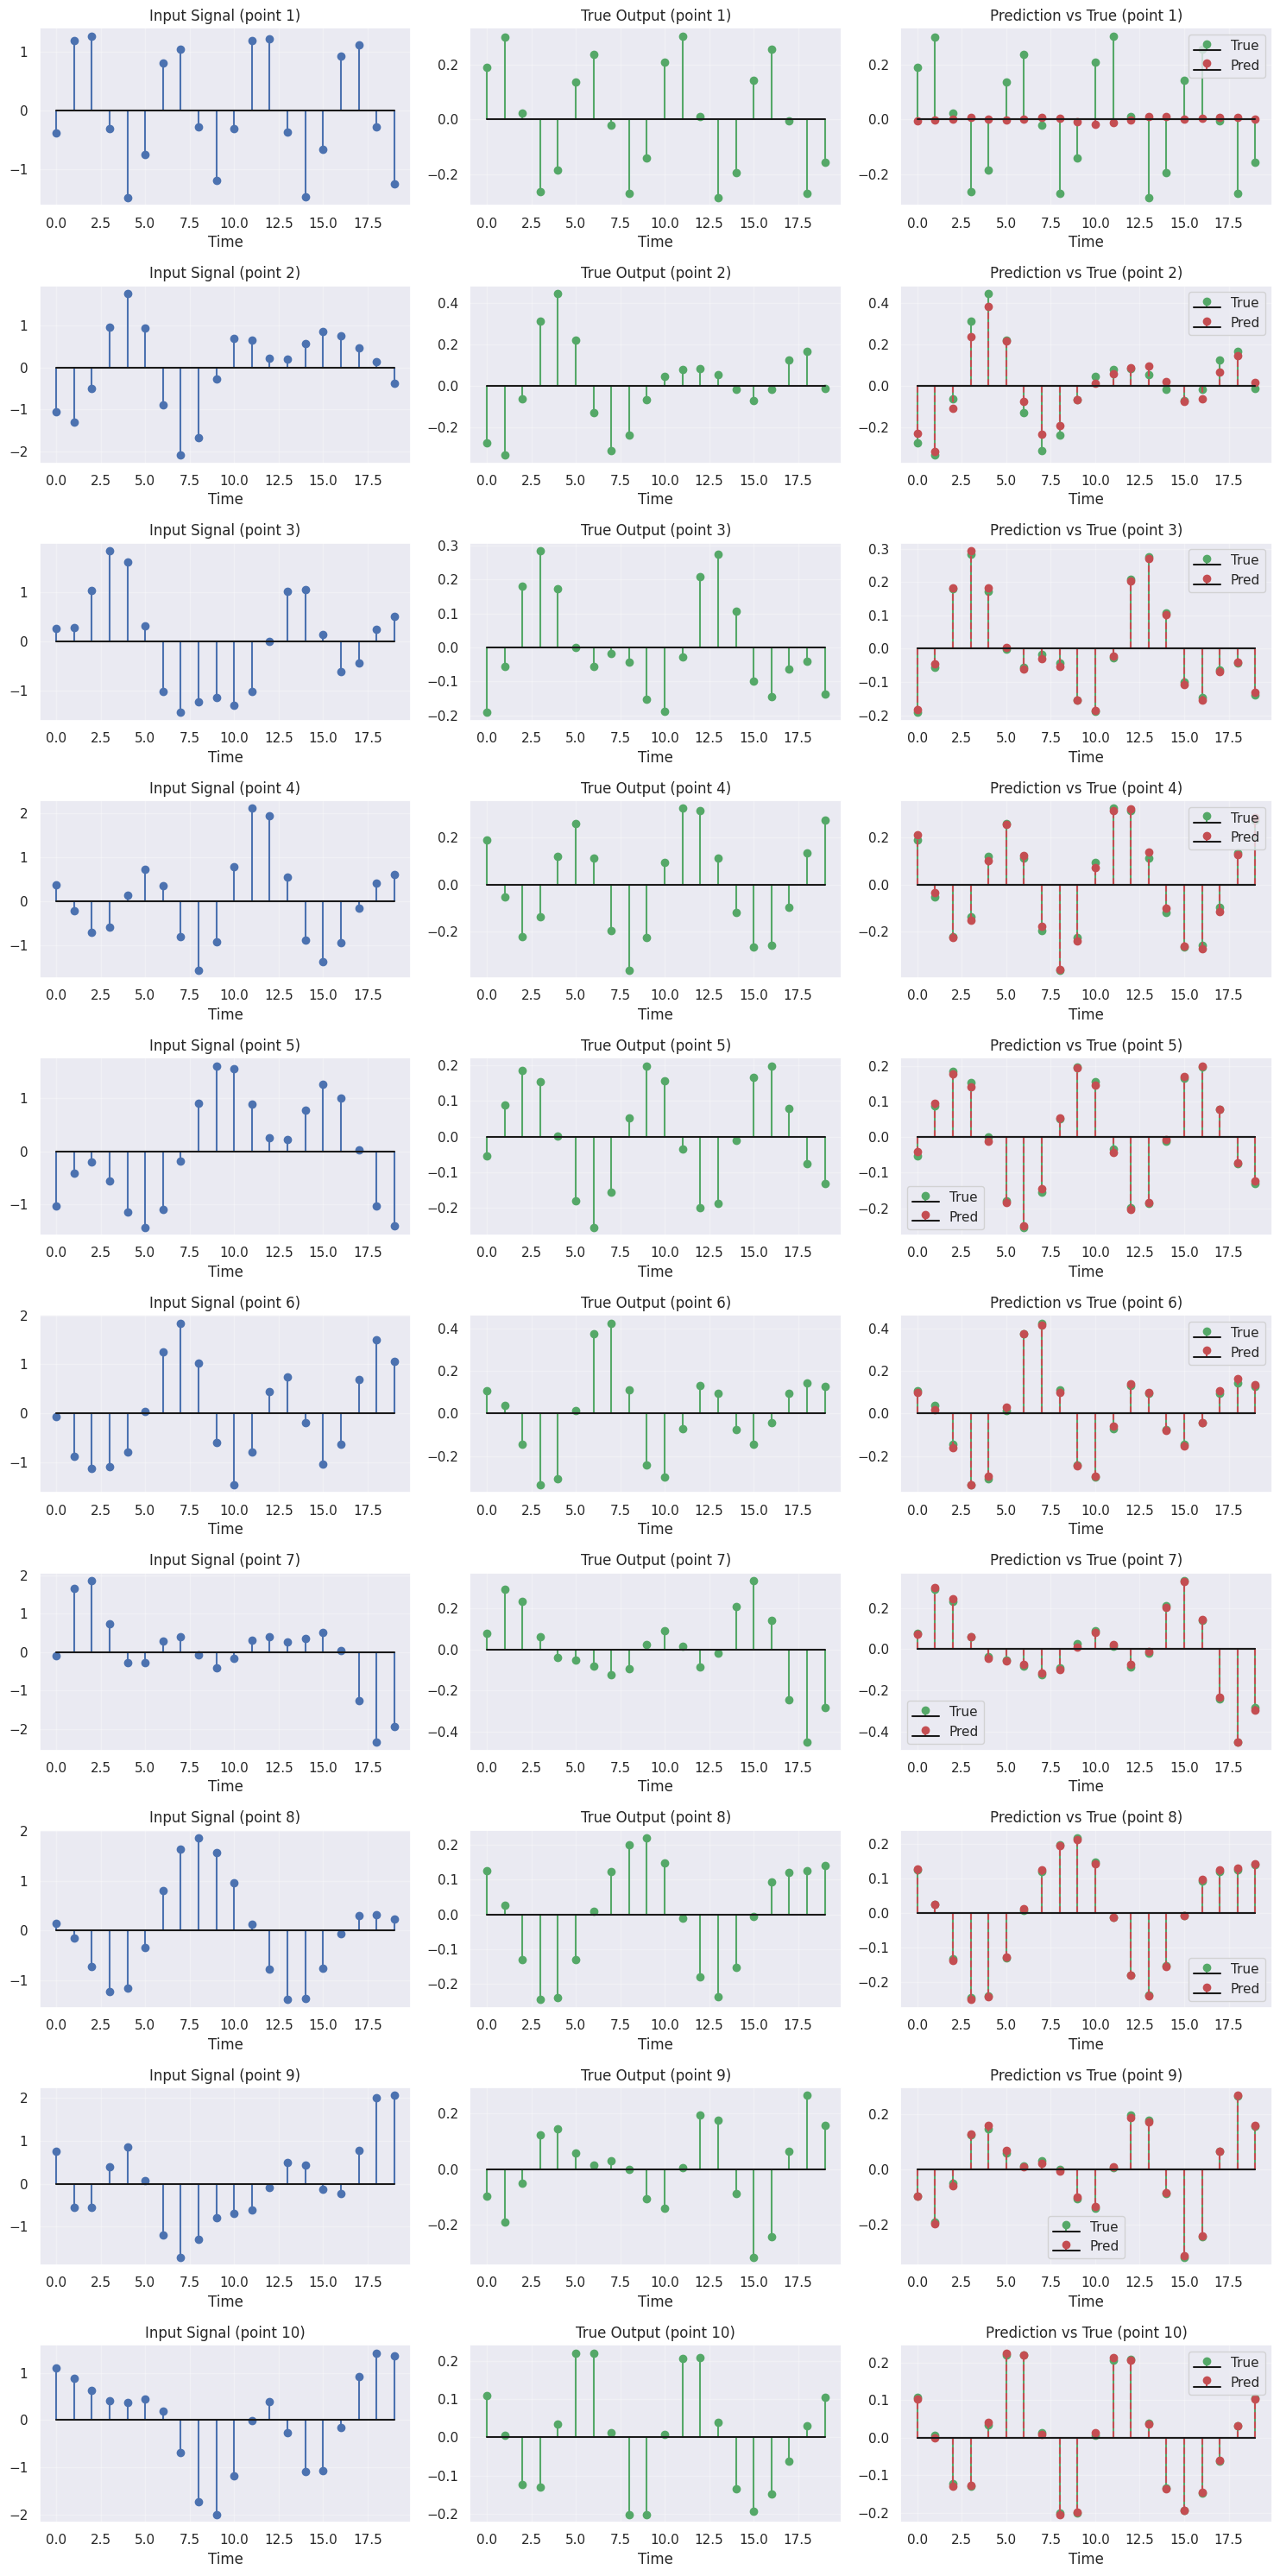

MSE for final point: 0.000017
Evaluating Frequency Period 20, FIR 20 from output/freq_p20_fir20_loss_space_time_b256_dec4_1443 ...
torch.Size([256, 55, 22])
torch.Size([256, 55, 1])


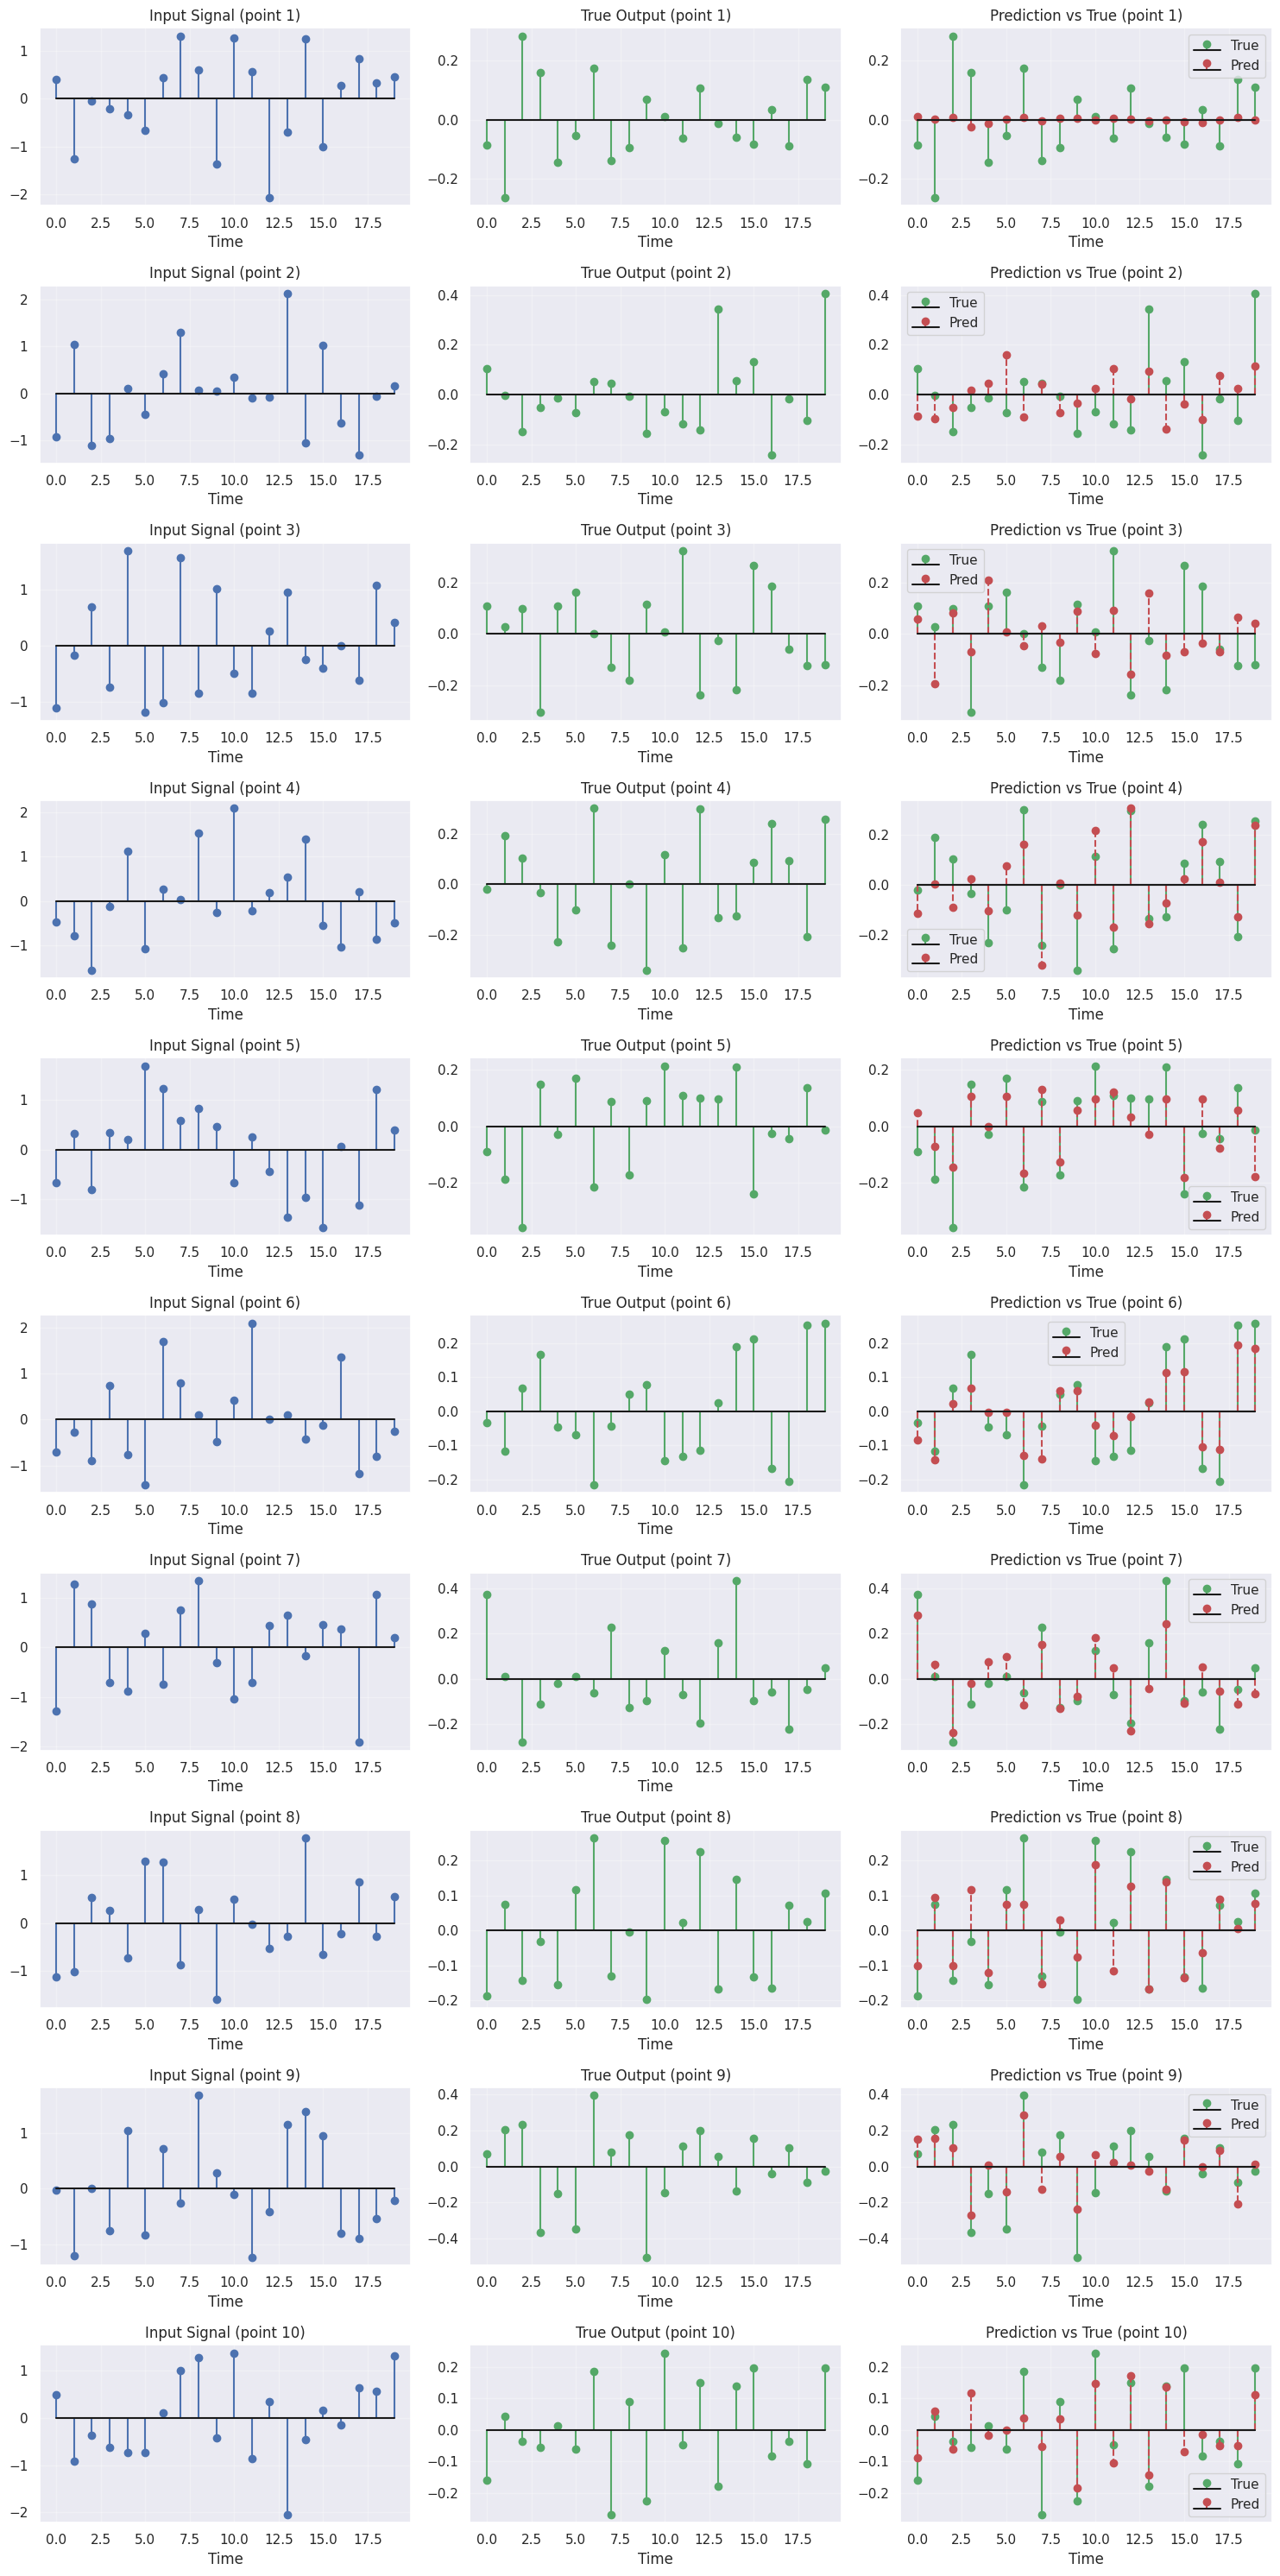

MSE for final point: 0.010729
Evaluating Time Period 20, FIR 5 from output/time_p20_fir5_context_batch256_dec4_1229 ...
torch.Size([256, 55, 20])
torch.Size([256, 55, 1])


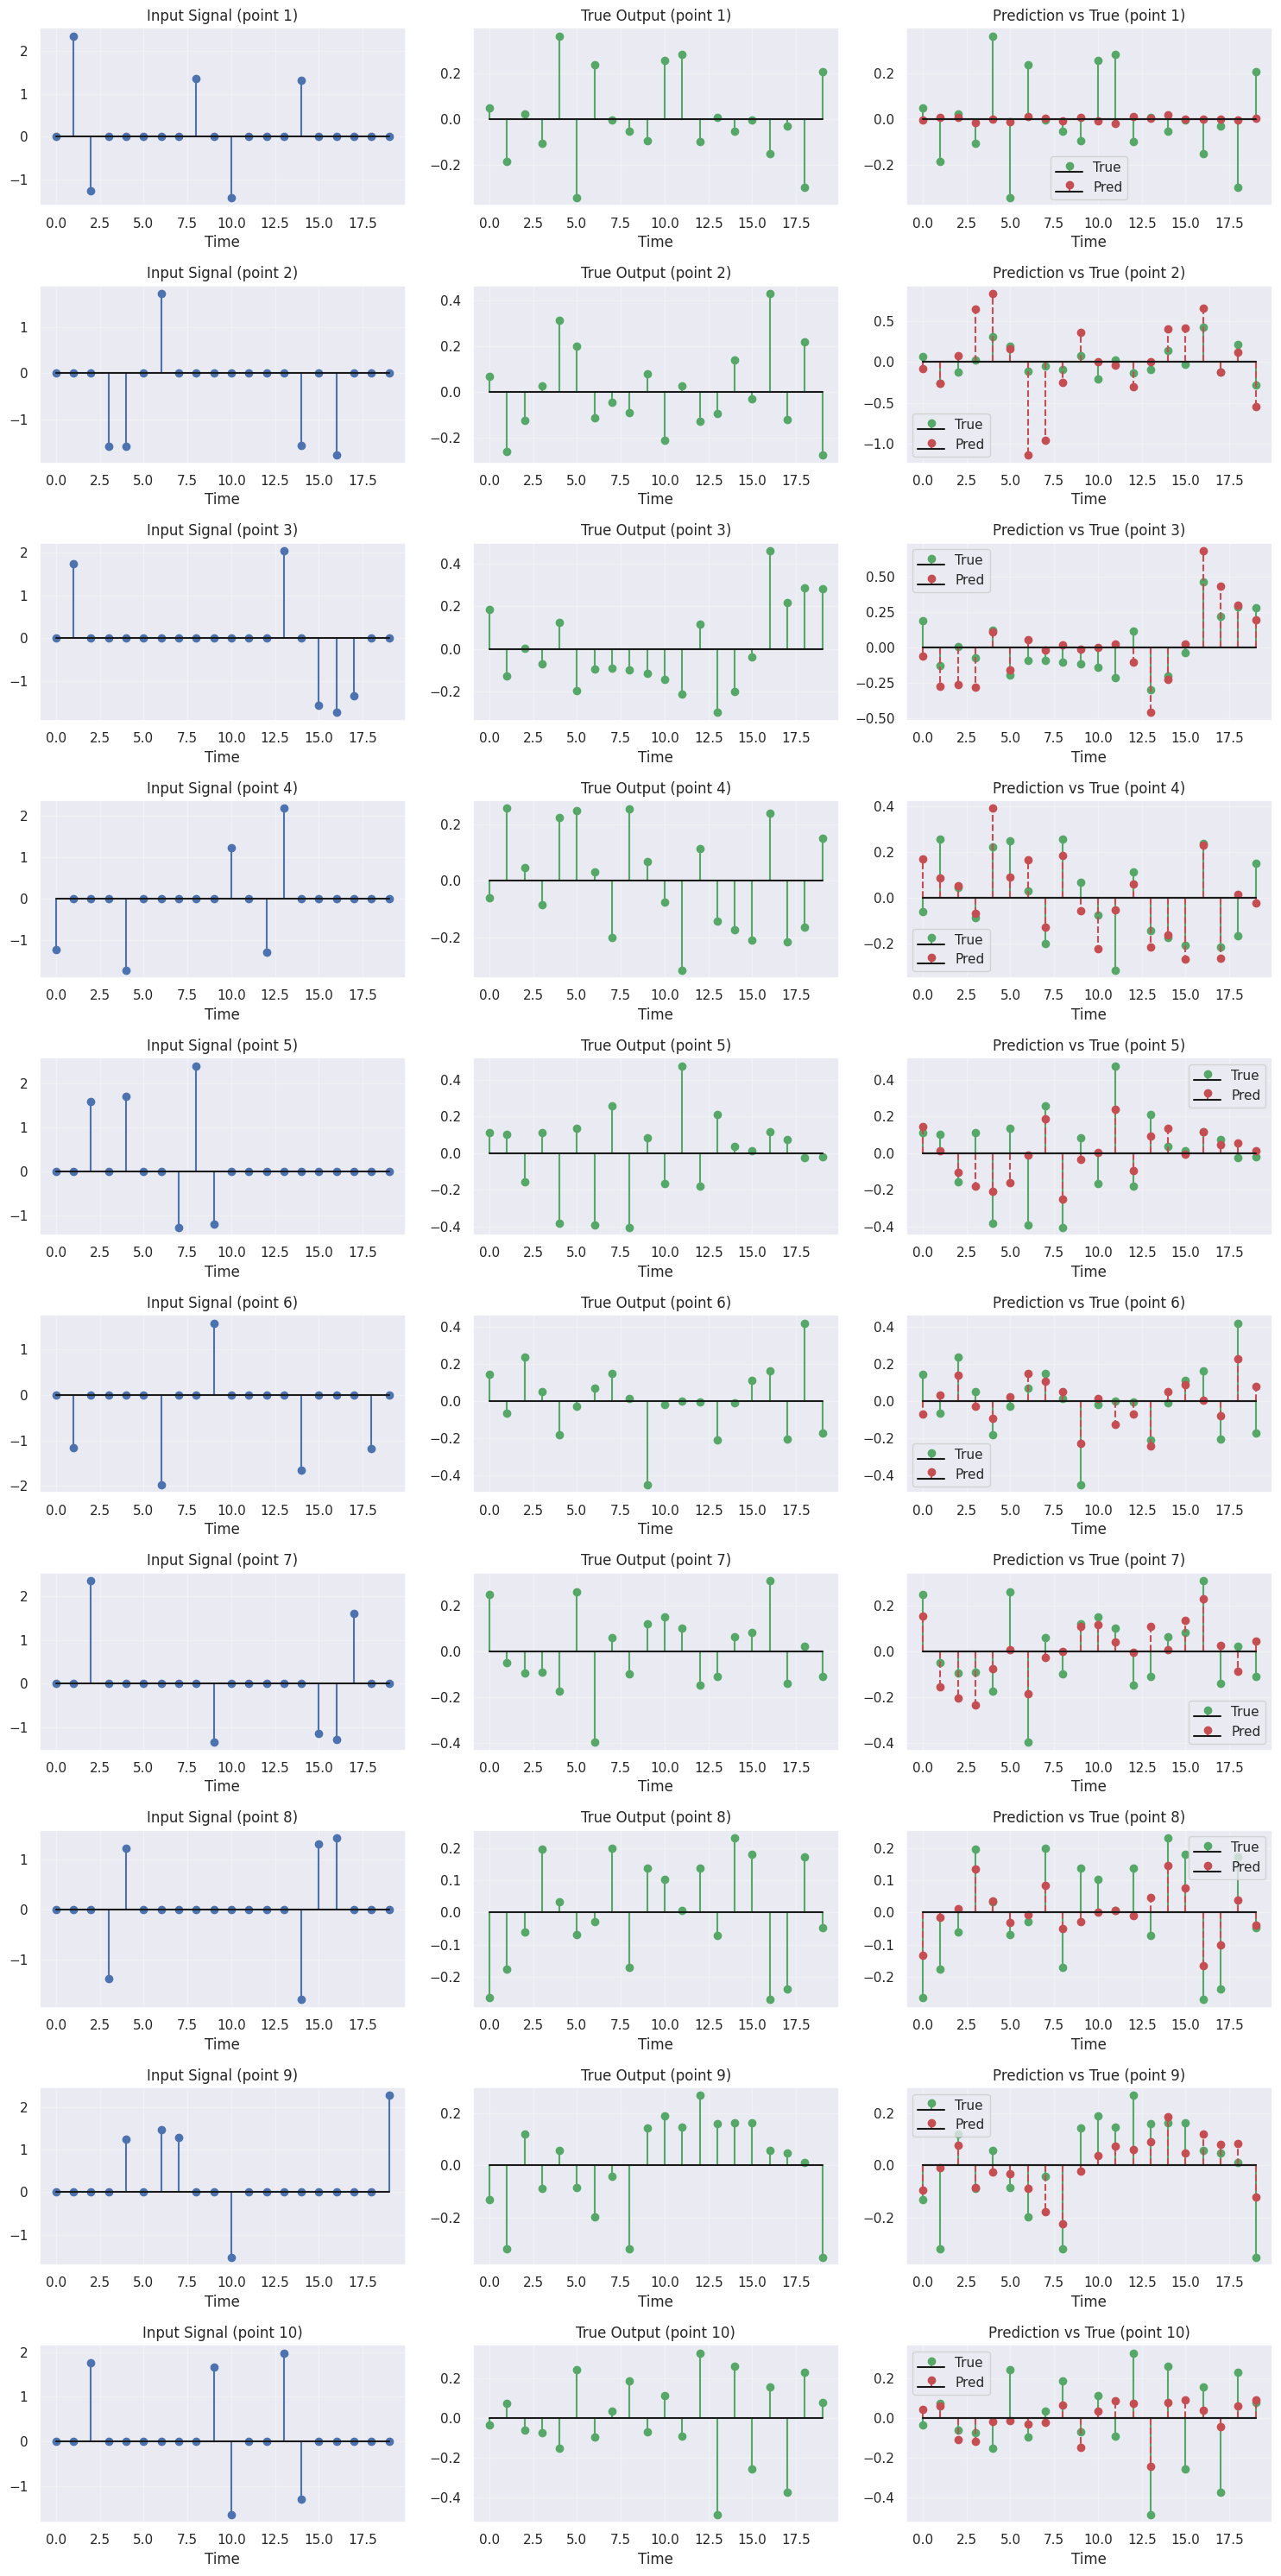

MSE for final point: 0.029621
Evaluating Time Period 20, FIR 20 from output/bigbatch_star ...
torch.Size([256, 71, 20])
torch.Size([256, 71, 1])


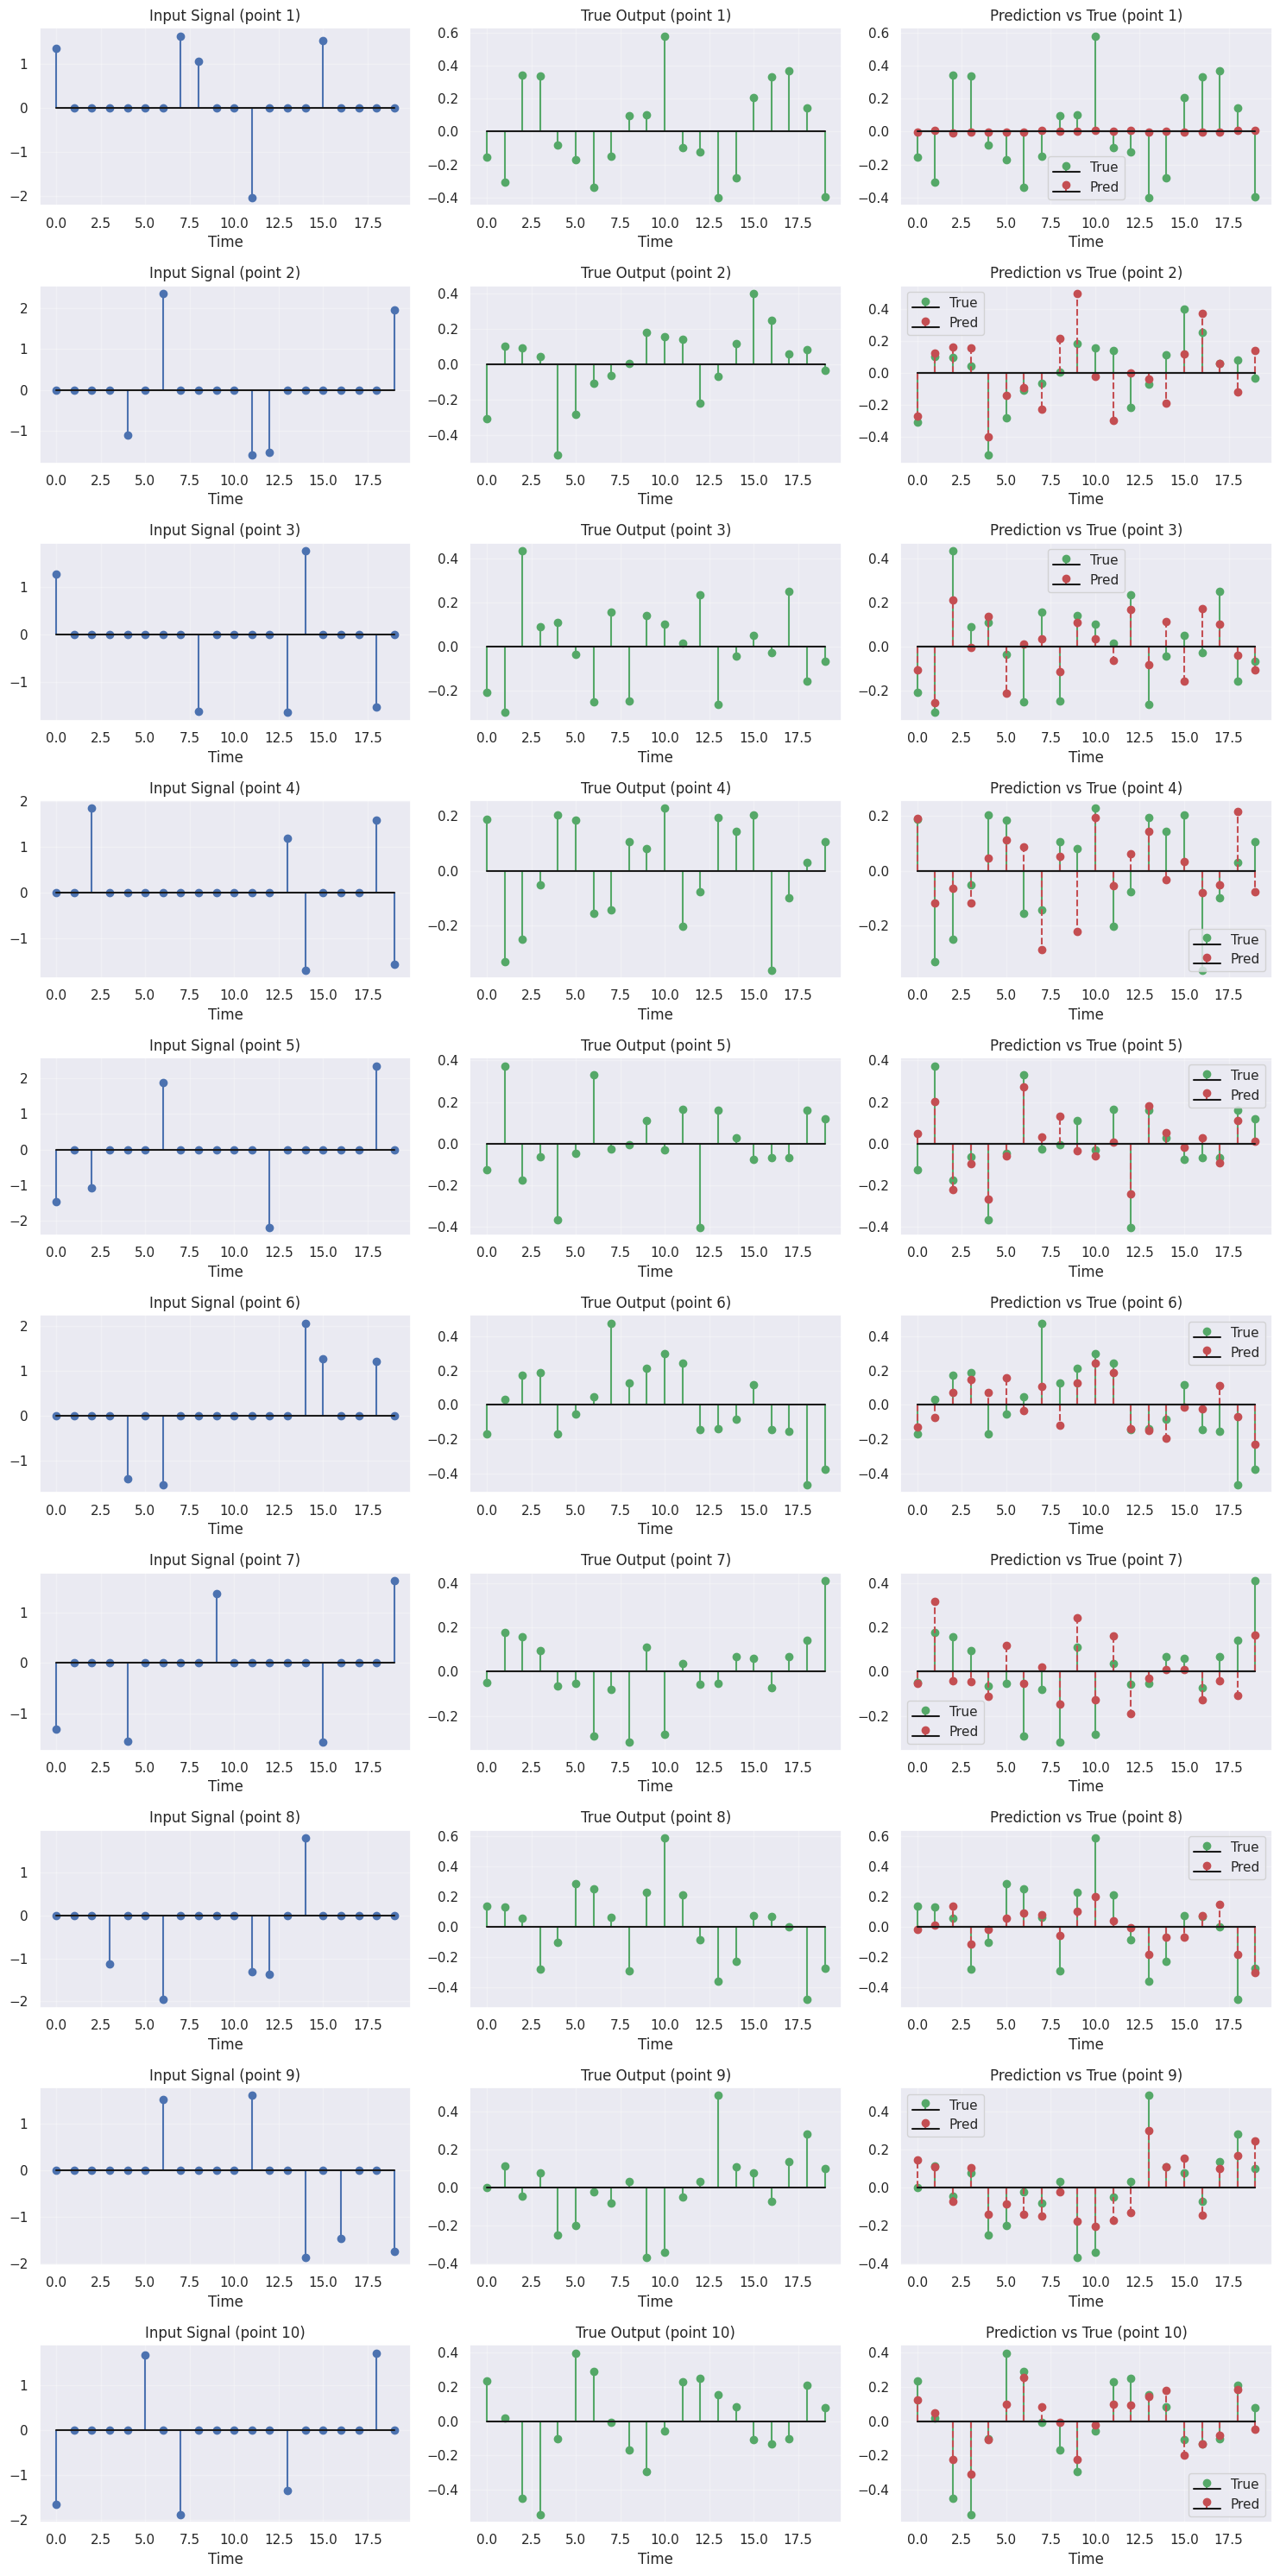

MSE for final point: 0.016393


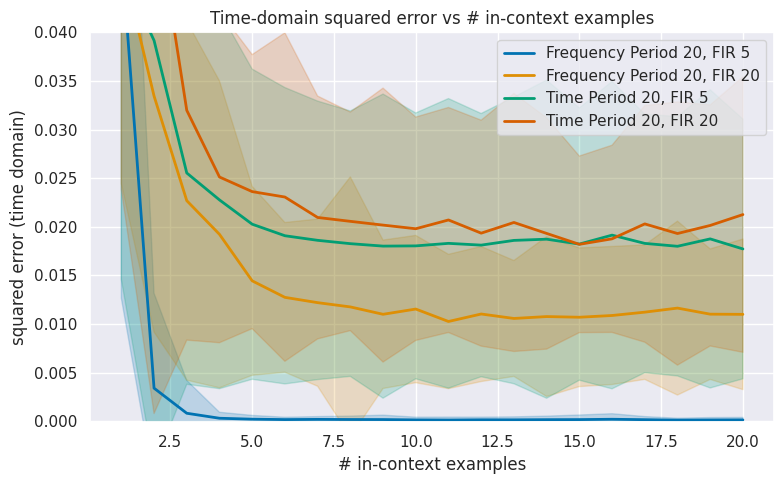

In [14]:
import numpy as np
from collections import OrderedDict

# Paths for the four models of interest (relative to project root)
model_specs = OrderedDict([
    ("Frequency Period 20, FIR 5", "output/freq_p20_fir5_loss_space_time_b256_dec4_1331"),
    ("Frequency Period 20, FIR 20", "output/freq_p20_fir20_loss_space_time_b256_dec4_1443"),
    ("Time Period 20, FIR 5", "output/time_p20_fir5_context_batch256_dec4_1229"),
    ("Time Period 20, FIR 20", "output/bigbatch_star"), 
])

# Common evaluation settings
batch_size = 256  # can be increased, but keep reasonable for memory

# Device selection (reuse logic from earlier cells)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

results_time_domain = OrderedDict()
num_points = None

for label, run_path in model_specs.items():
    print(f"Evaluating {label} from {run_path} ...")

    model, conf = get_model_from_run(run_path)
    model = model.to(device)
    model.eval()

    n_dims = conf.model.n_dims

    data_kwargs = dict(conf.training.data_kwargs)
    task_kwargs = dict(conf.training.task_kwargs)
    data_kwargs["device"] = device
    task_kwargs["device"] = device

    data_sampler = get_data_sampler(conf.training.data, n_dims, **data_kwargs)
    task_sampler = get_task_sampler(
        conf.training.task,
        n_dims,
        batch_size,
        **task_kwargs,
    )

    task = task_sampler()

    # Use the curriculum end-point to determine number of in-context examples
    this_num_points = conf.training.curriculum.points.end
    if num_points is None:
        num_points = this_num_points
    else:
        # Sanity check that all models use the same number of points
        if this_num_points != num_points:
            print(f"Warning: {label} has {this_num_points} points (expected {num_points}). Using its own value.")

    xs = data_sampler.sample_xs(b_size=batch_size, n_points=this_num_points)
    ys = task.evaluate(xs)
    print(xs.shape)

    # Forward pass
    with torch.no_grad():
        # Get threshold value per row (the n-th smallest)
        X_thresh = torch.kthvalue(torch.abs(xs), k=num_lowest, dim=2).values.unsqueeze(2)
        print(X_thresh.shape)
        # Mask values strictly greater than the n-th smallest
        mask = torch.abs(xs) > X_thresh  # keep values above threshold
        xs = xs * mask

        xs_device = xs.to(device)
        ys_device = ys.to(device)
        pred = model(xs_device, ys_device).cpu()

    # Convert to time domain if the model operates in frequency domain
    domain = conf.training.data_kwargs.domain
    if domain == "freq":
        # Last dim is 2p+1 (for DC/Nyquist), recover p used in time domain
        p = (xs.shape[-1] - 1) * 2
        xs_time = interleaved_freq_to_time(xs, p)
        ys_time = interleaved_freq_to_time(ys, p)
        pred_time = interleaved_freq_to_time(pred, p)
    else:
        xs_time = xs
        ys_time = ys
        pred_time = pred
    # Compute per-point MSE over the batch: shape (batch_size, T)
    preds_np = pred_time.cpu().numpy()
    ys_np = ys_time.cpu().numpy()
    # Average over feature dimension only (keep batch and time axes)
    per_point_mse = ((preds_np - ys_np) ** 2).mean(axis=2)

    mean_err = per_point_mse.mean(axis=0)  # shape (T,)
    std_err = per_point_mse.std(axis=0)    # shape (T,)

    results_time_domain[label] = {
        "mean": mean_err,
        "std": std_err,
    }
    plot_signal_examples(xs_time, ys_time, pred_time, conf, example_idx=0, n_points_to_show=10)

# Plot all models on the same chart with std shading
plt.figure(figsize=(8, 5))

# Truncate to the first 41 in-context examples to match the shortest run
max_T = 20
x_axis = np.arange(1, max_T + 1)

for idx, (label, stats) in enumerate(results_time_domain.items()):
    mean = stats["mean"][:max_T]
    std = stats["std"][:max_T]
    color = palette[idx % len(palette)] if "palette" in globals() else None

    plt.plot(x_axis, mean, label=label, linewidth=2, color=color)
    plt.fill_between(x_axis, mean - std, mean + std, alpha=0.2, color=color)

plt.xlabel("# in-context examples")
plt.ylabel("squared error (time domain)")
plt.ylim(-.0001, 0.04)
plt.title("Time-domain squared error vs # in-context examples")
plt.tight_layout()
plt.legend()
plt.show()
